<a href="https://colab.research.google.com/github/chahn85/UNOS_Synthetic/blob/main/Severity_based_TTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Cell 1: Install required packages
!pip install lifelines tqdm scikit-learn torch matplotlib seaborn numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [11]:
# Cell 2: Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from lifelines import KaplanMeierFitter
from tqdm import tqdm
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Cell 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths to your data files (adjust as needed)
syn_path = '/content/drive/MyDrive/SyntheticData/syn_unos_365.csv'
test_path = '/content/drive/MyDrive/SyntheticData/test_processed.csv'
val_path = '/content/drive/MyDrive/SyntheticData/val_processed.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Cell 4: Load data
# Load datasets
try:
    syn_df = pd.read_csv(syn_path)
    test_df = pd.read_csv(test_path)
    val_df = pd.read_csv(val_path)

    # Combine test and validation sets for the real data
    real_df = pd.concat([test_df, val_df], ignore_index=True)
    print("Data loaded successfully")

except Exception as e:
    print(f"Error loading data: {e}")

# Display basic information
print(f"Synthetic data shape: {syn_df.shape}")
print(f"Real data shape: {real_df.shape}")

# Display the first few rows of each dataset
print("\nSynthetic data preview:")
display(syn_df.head())

print("\nReal data preview:")
display(real_df.head())

Data loaded successfully
Synthetic data shape: (10000000, 18)
Real data shape: (9757, 18)

Synthetic data preview:


,Age,BMI,Na,Cr,INR,Bili,Albumin,MELD,tte,Gender,ABO,Dialysis,Etiology,Ethnicity,diab_group_labeled,Encephalopathy_Status,Ascites_Status,outcome
0,37.0,20.670914,139.0,0.680000,1.400000,3.600000,3.4,15.000000,70.776686,M,O,N,Biliary,White,No Diabetes,NaN,Slight,2
1,75.0,21.882297,135.0,1.090000,2.900000,17.519539,1.9,37.000000,1.000000,M,O,Y,Biliary,White,No Diabetes,Grade 1-2,Moderate,2
2,37.0,27.964562,138.0,1.500000,34.065144,51.871143,3.3,49.145179,1.000000,F,O,N,Alcohol,Black/African American,No Diabetes,NaN,NaN,2
3,69.0,26.999342,140.0,0.710000,1.000000,1.000000,4.2,6.000000,365.000000,M,O,N,Biliary,White,Diabetes,NaN,NaN,1
4,63.0,38.799426,135.0,10.078469,1.300000,2.000000,3.4,34.000000,365.000000,M,O,N,Viral,White,No Diabetes,Grade 1-2,Slight,1



Real data preview:


,Age,BMI,Na,Cr,INR,Bili,Albumin,MELD,tte,Gender,ABO,Dialysis,Etiology,Ethnicity,diab_group_labeled,Encephalopathy_Status,Ascites_Status,outcome
0,25.0,33.475635,128.0,1.00,3.30,13.6,2.1,33.0,3.0,M,A,N,Biliary,White,No Diabetes,NaN,Moderate,2
1,68.0,39.748469,128.0,1.00,1.50,3.1,2.5,22.0,93.0,F,O,N,NASH,White,No Diabetes,Grade 1-2,Slight,0
2,32.0,18.748562,136.0,0.62,1.60,2.9,1.9,17.0,49.0,M,B,N,Biliary,White,No Diabetes,NaN,Slight,2
3,58.0,40.144393,133.0,1.54,1.60,3.2,3.6,23.0,365.0,M,A,N,Alcohol,White,No Diabetes,NaN,Slight,1
4,49.0,29.497323,120.0,0.80,1.51,11.6,2.5,28.0,2.0,M,O,N,Biliary,White,No Diabetes,NaN,NaN,2


In [14]:
# Cell 5: Data preprocessing
# Define categorization function for MELD scores
def categorize_meld(meld_score):
    if meld_score <= 15:
        return "<=15"
    elif 16 <= meld_score <= 20:
        return "16-20"
    elif 21 <= meld_score <= 25:
        return "21-25"
    elif 26 <= meld_score <= 30:
        return "26-30"
    elif 31 <= meld_score <= 35:
        return "31-35"
    else:  # meld_score >= 36
        return "36-40+"

# Apply MELD categorization
real_df['MELD_cat'] = real_df['MELD'].apply(categorize_meld)
syn_df['MELD_cat'] = syn_df['MELD'].apply(categorize_meld)

# Keep all outcomes in synthetic data (0, 1, 2)
# Print outcome distribution
print("\nOutcome distribution in real data:")
print(real_df['outcome'].value_counts().sort_index())

print("\nOutcome distribution in synthetic data:")
print(syn_df['outcome'].value_counts().sort_index())

# Handle missing values
# For real_df
real_df['Ascites_Status'] = real_df['Ascites_Status'].fillna('None')
real_df['Encephalopathy_Status'] = real_df['Encephalopathy_Status'].fillna('None')

# For syn_df
syn_df['Ascites_Status'] = syn_df['Ascites_Status'].fillna('None')
syn_df['Encephalopathy_Status'] = syn_df['Encephalopathy_Status'].fillna('None')

# Define features to use
numeric_features = [
    'Na',
    'Cr',
    'INR',
    'Bili',
    'Albumin'
]

categorical_features = [
    'Gender',
    'Dialysis',
    'MELD_cat'
]


Outcome distribution in real data:
outcome
0    1080
1    2540
2    6137
Name: count, dtype: int64

Outcome distribution in synthetic data:
outcome
0    1109897
1    2274888
2    6615215
Name: count, dtype: int64


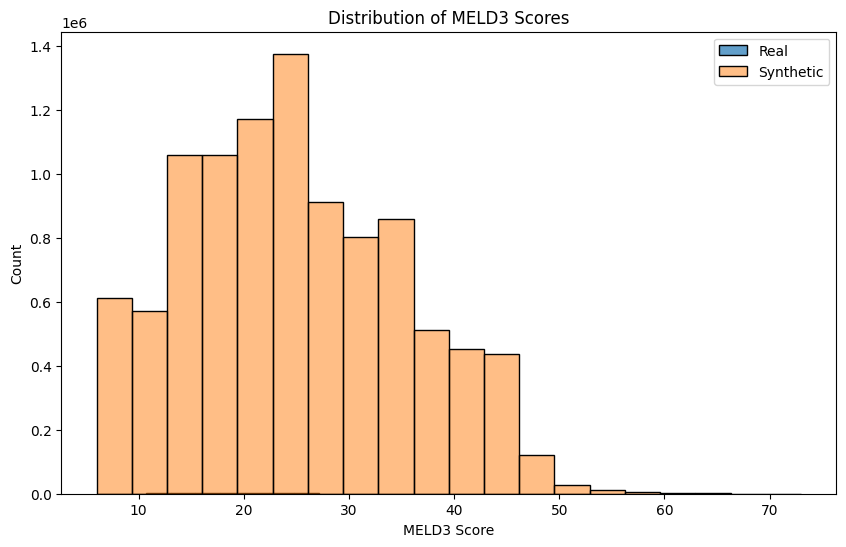

In [15]:
# Cell 6: Calculate MELD3 scores
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['Gender'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['Bili'])
    sodium = min(137, max(125, row['Na']))
    inr = max(1.0, row['INR'])

    # Set creatinine based on dialysis status
    if row['Dialysis'] == 'Y':
        creatinine = 3.0
    else:
        creatinine = min(3.0, max(1.0, row['Cr']))

    albumin = min(3.5, max(1.5, row['Albumin']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Apply the function to add a new column 'meld3' to real_df
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)

# Also calculate for synthetic data
syn_df['meld3'] = syn_df.apply(calculate_meld3, axis=1)

# Print MELD3 distribution
plt.figure(figsize=(10, 6))
sns.histplot(real_df['meld3'], bins=20, alpha=0.7, label='Real')
sns.histplot(syn_df['meld3'], bins=20, alpha=0.5, label='Synthetic')
plt.title('Distribution of MELD3 Scores')
plt.xlabel('MELD3 Score')
plt.ylabel('Count')
plt.legend()
plt.show()

In [16]:
# Cell 7: Feature preprocessing
# Scale numeric features
scaler = StandardScaler()
syn_numeric = syn_df[numeric_features].astype(float)
scaler = scaler.fit(syn_numeric)

# Process real numeric features
real_numeric = real_df[numeric_features].fillna(real_df[numeric_features].median()).astype(float)
real_numeric_scaled = scaler.transform(real_numeric)

# Process synthetic numeric features
syn_numeric_scaled = scaler.transform(syn_numeric)

# Process categorical features
# Get canonical feature names from synthetic data
syn_categorical_cols = categorical_features
syn_cat_tmp = syn_df[syn_categorical_cols].astype(str)
syn_cat_encoded_tmp = pd.get_dummies(syn_cat_tmp, drop_first=False)
cat_feature_names = syn_cat_encoded_tmp.columns
print("Categorical features after encoding:", list(cat_feature_names))

# Process real categorical features
real_cat = real_df[categorical_features].copy()
real_cat = real_cat.astype(str)

# One-hot encode
real_cat_encoded = pd.get_dummies(real_cat, drop_first=False)
real_cat_encoded = real_cat_encoded.reindex(columns=cat_feature_names, fill_value=0)

# Process synthetic categorical features
syn_cat = syn_df[syn_categorical_cols].astype(str)
syn_cat_encoded = pd.get_dummies(syn_cat, drop_first=False)

# Combine real features
real_features = np.hstack([real_numeric_scaled, real_cat_encoded.values]).astype(np.float32)
print("Real features shape:", real_features.shape)

# Combine synthetic features
syn_features = np.hstack([syn_numeric_scaled, syn_cat_encoded.values]).astype(np.float32)
print("Synthetic features shape:", syn_features.shape)

Categorical features after encoding: ['Gender_F', 'Gender_M', 'Dialysis_A', 'Dialysis_N', 'Dialysis_Y', 'MELD_cat_16-20', 'MELD_cat_21-25', 'MELD_cat_26-30', 'MELD_cat_31-35', 'MELD_cat_36-40+', 'MELD_cat_<=15']
Real features shape: (9757, 16)
Synthetic features shape: (10000000, 16)


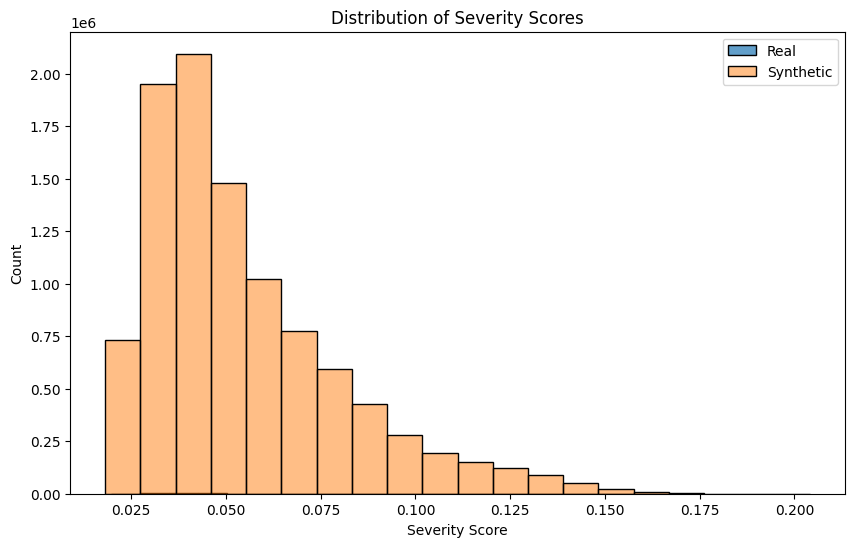

In [17]:
# Cell 8: Create severity score function
def create_severity_score(df):
    """
    Create a composite severity score from multiple clinical indicators

    Args:
        df: DataFrame with patient data

    Returns:
        Series with severity scores
    """
    # Components that indicate severity (higher = more severe)
    components = []

    # MELD3 score (if available)
    if 'meld3' in df.columns:
        # Normalize MELD3 to 0-1 range (typical range 6-40)
        meld3_norm = (df['meld3'] - 6) / 34
        meld3_norm = meld3_norm.clip(0, 1)
        components.append(meld3_norm * 3.0)  # Weight factor of 3

    # Bilirubin (indicator of liver function)
    if 'Bili' in df.columns:
        # Normalize (typical range 0.1-30)
        bili_norm = (df['Bili'] - 0.1) / 29.9
        bili_norm = bili_norm.clip(0, 1)
        components.append(bili_norm * 1.5)  # Weight factor of 1.5

    # INR (clotting factor)
    if 'INR' in df.columns:
        # Normalize (typical range 0.5-10)
        inr_norm = (df['INR'] - 0.5) / 9.5
        inr_norm = inr_norm.clip(0, 1)
        components.append(inr_norm * 1.5)  # Weight factor of 1.5

    # Sodium (inversely related to severity)
    if 'Na' in df.columns:
        # Normalize sodium (typical range 125-150)
        # Note: Lower sodium is worse, so we invert
        na_norm = 1 - ((df['Na'] - 125) / 25)
        na_norm = na_norm.clip(0, 1)
        components.append(na_norm * 0.8)  # Weight factor of 0.8

    # Albumin (inversely related to severity)
    if 'Albumin' in df.columns:
        # Normalize albumin (typical range 1.5-5.0)
        # Note: Lower albumin is worse, so we invert
        alb_norm = 1 - ((df['Albumin'] - 1.5) / 3.5)
        alb_norm = alb_norm.clip(0, 1)
        components.append(alb_norm * 0.8)  # Weight factor of 0.8

    # Creatinine
    if 'Cr' in df.columns:
        # Normalize creatinine (typical range 0.5-10)
        cr_norm = (df['Cr'] - 0.5) / 9.5
        cr_norm = cr_norm.clip(0, 1)
        components.append(cr_norm)  # Weight factor of 1.0

    # Dialysis (categorical)
    if 'Dialysis' in df.columns:
        dialysis = (df['Dialysis'] == 'Y').astype(float)
        components.append(dialysis * 2.0)  # Weight factor of 2.0

    # Clinical complications
    # Encephalopathy
    if 'Encephalopathy_Status' in df.columns:
        enceph_map = {
            'None': 0.0,
            'NaN': 0.0,
            'Grade 1-2': 0.5,
            'Grade 3-4': 1.0
        }
        enceph_score = df['Encephalopathy_Status'].map(lambda x: enceph_map.get(x, 0.0))
        components.append(enceph_score * 1.2)  # Weight factor of 1.2

    # Ascites
    if 'Ascites_Status' in df.columns:
        ascites_map = {
            'None': 0.0,
            'NaN': 0.0,
            'Slight': 0.5,
            'Moderate': 0.8,
            'Severe': 1.0
        }
        ascites_score = df['Ascites_Status'].map(lambda x: ascites_map.get(x, 0.0))
        components.append(ascites_score * 1.2)  # Weight factor of 1.2

    # Combine all components
    severity = sum(components) / len(components)

    # Apply sigmoid to normalize between 0 and 1
    # This creates a more balanced distribution
    severity = expit(severity * 2 - 4)  # Scaling and shifting for appropriate distribution

    return severity

# Calculate severity scores
real_severity = create_severity_score(real_df)
syn_severity = create_severity_score(syn_df)

# Plot severity distributions
plt.figure(figsize=(10, 6))
sns.histplot(real_severity, bins=20, alpha=0.7, label='Real')
sns.histplot(syn_severity, bins=20, alpha=0.5, label='Synthetic')
plt.title('Distribution of Severity Scores')
plt.xlabel('Severity Score')
plt.ylabel('Count')
plt.legend()
plt.show()

# Add severity scores to dataframes
real_df['severity_score'] = real_severity
syn_df['severity_score'] = syn_severity

In [18]:
# Cell 9: Define the PairDataset for contrastive learning
class SeverityPairDataset(Dataset):
    def __init__(self, features, severity_indicators, outcomes, times, n_pairs=10000, severity_weight=0.7):
        """
        Create a dataset focused on pairing patients with similar disease severity
        """
        self.features = np.array(features, dtype=np.float32)
        self.severity = np.array(severity_indicators, dtype=np.float32)
        self.outcomes = np.array(outcomes, dtype=np.float32)
        self.times = np.array(times, dtype=np.float32)

        # Normalize severity and times for better comparisons
        severity_scaler = MinMaxScaler()
        self.severity_norm = severity_scaler.fit_transform(self.severity.reshape(-1, 1)).flatten()

        # For time, use a different approach: log scaling to emphasize differences in shorter times
        max_time = np.max(self.times)
        self.times_norm = np.log1p(self.times) / np.log1p(max_time)  # log1p to handle zeros

        self.pairs = []
        self.labels = []
        N = self.features.shape[0]
        rng = np.random.RandomState(42)

        # Generate stratified pairs based on severity
        # First, bin patients by severity
        n_bins = 10
        severity_bins = np.linspace(0, 1, n_bins+1)
        bin_indices = [[] for _ in range(n_bins)]

        for i, sev in enumerate(self.severity_norm):
            bin_idx = min(int(sev * n_bins), n_bins-1)
            bin_indices[bin_idx].append(i)

        # Generate pairs with a focus on similar severity
        count = 0
        print(f"Generating {n_pairs} severity-focused pairs...")

        while count < n_pairs:
            # First decide whether to sample from same bin (80% chance) or adjacent bin (20% chance)
            if rng.random() < 0.8:
                # Same bin sampling
                bin_idx = rng.choice(range(n_bins))
                if len(bin_indices[bin_idx]) < 2:  # Need at least 2 patients in bin
                    continue

                # Select two different patients from the same bin
                idx_i, idx_j = rng.choice(bin_indices[bin_idx], size=2, replace=False)
            else:
                # Adjacent bin sampling
                bin_idx = rng.choice(range(n_bins-1))  # Pick a bin that has a next bin
                if not bin_indices[bin_idx] or not bin_indices[bin_idx+1]:
                    continue

                # Select one patient from each bin
                idx_i = rng.choice(bin_indices[bin_idx])
                idx_j = rng.choice(bin_indices[bin_idx+1])

            # Calculate severity similarity (inversely proportional to difference)
            severity_diff = abs(self.severity_norm[idx_i] - self.severity_norm[idx_j])
            severity_sim = 1.0 - severity_diff

            # Calculate time similarity
            time_diff = abs(self.times_norm[idx_i] - self.times_norm[idx_j])
            time_sim = 1.0 - time_diff

            # Calculate outcome similarity
            outcome_sim = 1.0 if self.outcomes[idx_i] == self.outcomes[idx_j] else 0.5

            # Calculate combined similarity with emphasis on severity
            combined_sim = (severity_weight * severity_sim +
                           (1 - severity_weight) * 0.7 * time_sim +
                           (1 - severity_weight) * 0.3 * outcome_sim)

            # Binary label with high threshold to focus on very similar pairs
            label = 1.0 if combined_sim > 0.75 else 0.0

            self.pairs.append((idx_i, idx_j))
            self.labels.append(label)
            count += 1

            if count % 1000 == 0:
                print(f"Generated {count} pairs...")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        return (torch.tensor(self.features[i], dtype=torch.float32),
                torch.tensor(self.features[j], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))

In [19]:
# Cell 10: Define the neural network and training functions
class SeverityMetricNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
        super(SeverityMetricNet, self).__init__()

        # Build encoder layers
        layers = []
        current_dim = input_dim

        # Add hidden layers with batch normalization and dropout
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            current_dim = hidden_dim

        # Final embedding layer
        layers.append(nn.Linear(current_dim, embedding_dim))

        self.net = nn.Sequential(*layers)

        # Transformation head with batch normalization
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )

        # Severity prediction head
        self.severity_head = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Severity is between 0 and 1
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x, return_severity=False):
        emb = self.net(x)
        transformed = self.transform(emb)
        normalized = F.normalize(transformed, p=2, dim=1)

        if return_severity:
            severity_pred = self.severity_head(normalized)
            return normalized, severity_pred
        return normalized

# Contrastive loss function with temperature scaling
def contrastive_loss(x1, x2, label, margin=1.0, temperature=0.1):
    d = torch.norm(x1 - x2, p=2, dim=1)
    d_scaled = d / temperature
    loss_sim = label * d_scaled**2
    loss_dissim = (1 - label) * torch.clamp(margin - d_scaled, min=0.0)**2
    return torch.mean(loss_sim + loss_dissim)

In [20]:
# Cell 11: Create training function
def train_model(model, train_loader, optimizer, n_epochs=50, patience=5, device='cuda'):
    """Train the model with early stopping"""
    best_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0

        for batch_idx, (x1, x2, label) in enumerate(train_loader):
            x1, x2, label = x1.to(device), x2.to(device), label.to(device)

            # Forward pass
            emb1 = model(x1)
            emb2 = model(x2)
            loss = contrastive_loss(emb1, emb2, label)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item() * x1.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Load best model
    model.load_state_dict(torch.load('best_model.pt'))
    return model

In [21]:
# Cell 12: Prepare and train the model
# Initialize dataset and dataloader
pair_dataset = SeverityPairDataset(
    real_features,
    real_severity.values,
    real_df['outcome'].values,
    real_df['tte'].values,
    n_pairs=10000,
    severity_weight=0.7
)

batch_size = 64
train_loader = DataLoader(pair_dataset, batch_size=batch_size, shuffle=True)

# Initialize model
input_dim = real_features.shape[1]
embedding_dim = 64
model = SeverityMetricNet(input_dim, embedding_dim).to(device)

# Initialize optimizer
optimizer = torch.optim.AdamW([
    {'params': model.net.parameters(), 'lr': 1e-3},
    {'params': model.transform.parameters(), 'lr': 5e-4},
    {'params': model.severity_head.parameters(), 'lr': 2e-3}
], weight_decay=1e-4)

# Train model
model = train_model(
    model,
    train_loader,
    optimizer,
    n_epochs=50,  # Adjust as needed
    patience=5,
    device=device
)

Generating 10000 severity-focused pairs...
Generated 1000 pairs...
Generated 2000 pairs...
Generated 3000 pairs...
Generated 4000 pairs...
Generated 5000 pairs...
Generated 6000 pairs...
Generated 7000 pairs...
Generated 8000 pairs...
Generated 9000 pairs...
Generated 10000 pairs...
Epoch 1/50, Loss: 40.1392
Epoch 2/50, Loss: 14.7797
Epoch 3/50, Loss: 12.4673
Epoch 4/50, Loss: 10.5239
Epoch 5/50, Loss: 8.1384
Epoch 6/50, Loss: 5.6432
Epoch 7/50, Loss: 2.0303
Epoch 8/50, Loss: 0.0346
Epoch 9/50, Loss: 0.0221
Epoch 10/50, Loss: 0.0207
Epoch 11/50, Loss: 0.0199
Epoch 12/50, Loss: 0.0195
Epoch 13/50, Loss: 0.0192
Epoch 14/50, Loss: 0.0192
Epoch 15/50, Loss: 0.0189
Epoch 16/50, Loss: 0.0188
Epoch 17/50, Loss: 0.0187
Epoch 18/50, Loss: 0.0185
Epoch 19/50, Loss: 0.0183
Epoch 20/50, Loss: 0.0183
Epoch 21/50, Loss: 0.0181
Epoch 22/50, Loss: 0.0180
Epoch 23/50, Loss: 0.0180
Epoch 24/50, Loss: 0.0180
Epoch 25/50, Loss: 0.0178
Epoch 26/50, Loss: 0.0177
Epoch 27/50, Loss: 0.0177
Epoch 28/50, Loss: 

In [22]:
# Cell 13: Compute embeddings
def compute_embeddings(model, features, batch_size=512):
    """Compute embeddings in batches"""
    model.eval()
    embeddings = []

    with torch.no_grad():
        # Process in batches
        for i in range(0, len(features), batch_size):
            batch = torch.tensor(
                features[i:i+batch_size],
                dtype=torch.float32,
                device=device
            )
            batch_embeddings = model(batch).cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Compute embeddings for real and synthetic patients
real_embeddings = compute_embeddings(model, real_features)
syn_embeddings = compute_embeddings(model, syn_features)

print("Real embeddings shape:", real_embeddings.shape)
print("Synthetic embeddings shape:", syn_embeddings.shape)

Real embeddings shape: (9757, 64)
Synthetic embeddings shape: (10000000, 64)


In [23]:
# Cell 14: Define severity-based nearest neighbors search function
def severity_based_nearest_neighbors(
    real_idx, real_embeddings, real_severity,
    syn_embeddings, syn_severity, syn_times, syn_outcomes,
    k_neighbors=100, severity_tolerance=0.2):
    """
    Find nearest neighbors with similar severity levels
    """
    # Get real patient data
    real_emb = real_embeddings[real_idx].reshape(1, -1)
    real_sev = real_severity[real_idx]

    # First, filter synthetic patients by severity
    severity_lower = max(0, real_sev - severity_tolerance)
    severity_upper = min(1, real_sev + severity_tolerance)

    # Find indices of synthetic patients within severity range
    severity_mask = (syn_severity >= severity_lower) & (syn_severity <= severity_upper)
    severity_indices = np.where(severity_mask)[0]

    # If too few patients match severity criteria, relax the filtering
    if len(severity_indices) < k_neighbors * 2:
        # Expand the range until we have enough patients
        expansion = 0.05  # Start with small expansion
        while len(severity_indices) < k_neighbors * 2 and expansion < 0.5:
            severity_lower = max(0, real_sev - (severity_tolerance + expansion))
            severity_upper = min(1, real_sev + (severity_tolerance + expansion))
            severity_mask = (syn_severity >= severity_lower) & (syn_severity <= severity_upper)
            severity_indices = np.where(severity_mask)[0]
            expansion += 0.05

    # If still too few, use all synthetic patients
    if len(severity_indices) < k_neighbors:
        severity_indices = np.arange(len(syn_embeddings))

    # Get embeddings for severity-filtered patients
    filtered_embeddings = syn_embeddings[severity_indices]

    # Now find nearest neighbors among severity-filtered patients
    nbrs = NearestNeighbors(n_neighbors=min(k_neighbors, len(filtered_embeddings)),
                           algorithm='ball_tree')
    nbrs.fit(filtered_embeddings)

    # Find nearest neighbors
    distances, indices = nbrs.kneighbors(real_emb)

    # Map back to original synthetic indices
    original_indices = severity_indices[indices[0]]

    # Get neighbor data
    neighbor_distances = distances[0]
    neighbor_times = syn_times[original_indices]
    neighbor_outcomes = syn_outcomes[original_indices]
    neighbor_severity = syn_severity[original_indices]

    # Calculate statistics
    # Group by outcome
    death_mask = neighbor_outcomes == 0
    censor_mask = neighbor_outcomes == 1
    tx_mask = neighbor_outcomes == 2

    n_death = sum(death_mask)
    n_censor = sum(censor_mask)
    n_tx = sum(tx_mask)

    # Median times by outcome
    death_median = np.median(neighbor_times[death_mask]) if n_death > 0 else np.nan
    censor_median = np.median(neighbor_times[censor_mask]) if n_censor > 0 else np.nan
    tx_median = np.median(neighbor_times[tx_mask]) if n_tx > 0 else np.nan

    # Proportion of each outcome
    death_prop = n_death / len(neighbor_outcomes) if len(neighbor_outcomes) > 0 else 0
    censor_prop = n_censor / len(neighbor_outcomes) if len(neighbor_outcomes) > 0 else 0
    tx_prop = n_tx / len(neighbor_outcomes) if len(neighbor_outcomes) > 0 else 0

    # Overall median and weighted median
    overall_median = np.median(neighbor_times)

    # Apply inverse distance weighting
    weights = 1.0 / (neighbor_distances + 1e-6)

    # Sort by time
    sorted_indices = np.argsort(neighbor_times)
    sorted_times = neighbor_times[sorted_indices]
    sorted_weights = weights[sorted_indices]

    # Calculate cumulative weights
    cum_weights = np.cumsum(sorted_weights)

    # Find median index (where cumulative weight exceeds half total weight)
    median_idx = np.searchsorted(cum_weights, cum_weights[-1] / 2)

    # Get weighted median (preventing index out of bounds)
    if median_idx >= len(sorted_times):
        weighted_median = sorted_times[-1]
    else:
        weighted_median = sorted_times[median_idx]

    return {
        'neighbor_indices': original_indices,
        'neighbor_distances': neighbor_distances,
        'neighbor_times': neighbor_times,
        'neighbor_outcomes': neighbor_outcomes,
        'neighbor_severity': neighbor_severity,
        'n_death': n_death,
        'n_censor': n_censor,
        'n_tx': n_tx,
        'death_median': death_median,
        'censor_median': censor_median,
        'tx_median': tx_median,
        'death_proportion': death_prop,
        'censor_proportion': censor_prop,
        'tx_proportion': tx_prop,
        'overall_median': overall_median,
        'weighted_median': weighted_median,
        'severity_range': (severity_lower, severity_upper),
        'severity_filtered_count': len(severity_indices)
    }


Patient 5226
Severity score: 0.039
MELD3 score: 22
Outcome: 2
Actual TTE: 11.0
Predicted TTE (weighted median): 32.0
Number of neighbors by outcome: Death=12, Censor=9, Transplant=79
Outcome proportions: Death=0.12, Censor=0.09, Transplant=0.79
Severity range: 0.000-0.239


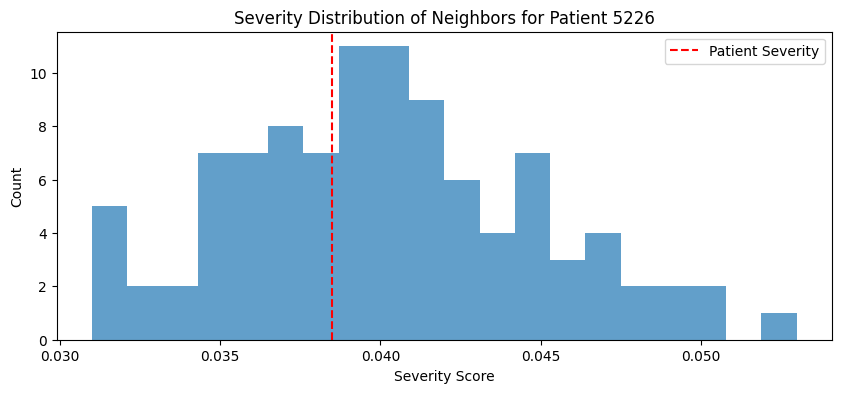


Patient 2406
Severity score: 0.033
MELD3 score: 13
Outcome: 2
Actual TTE: 286.0
Predicted TTE (weighted median): 365.0
Number of neighbors by outcome: Death=6, Censor=51, Transplant=43
Outcome proportions: Death=0.06, Censor=0.51, Transplant=0.43
Severity range: 0.000-0.233


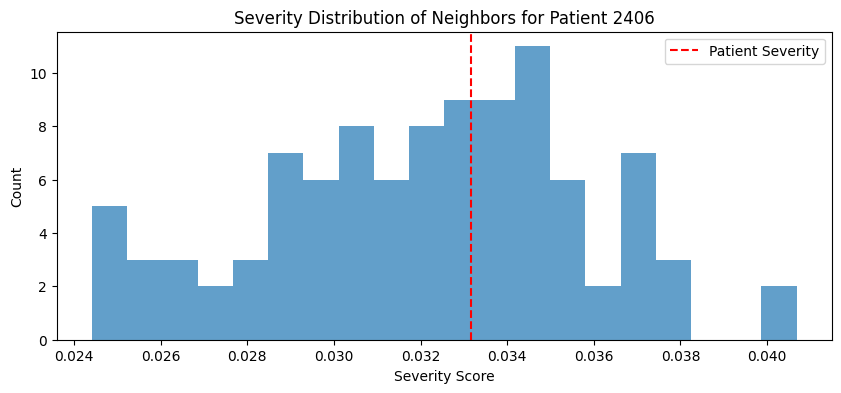


Patient 1253
Severity score: 0.049
MELD3 score: 27
Outcome: 2
Actual TTE: 11.0
Predicted TTE (weighted median): 24.8
Number of neighbors by outcome: Death=13, Censor=7, Transplant=80
Outcome proportions: Death=0.13, Censor=0.07, Transplant=0.80
Severity range: 0.000-0.249


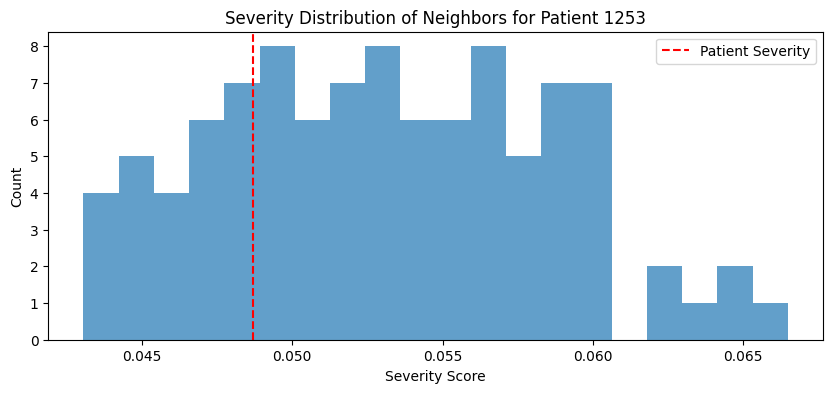


Patient 96
Severity score: 0.050
MELD3 score: 25
Outcome: 2
Actual TTE: 1.0
Predicted TTE (weighted median): 39.0
Number of neighbors by outcome: Death=12, Censor=7, Transplant=81
Outcome proportions: Death=0.12, Censor=0.07, Transplant=0.81
Severity range: 0.000-0.250


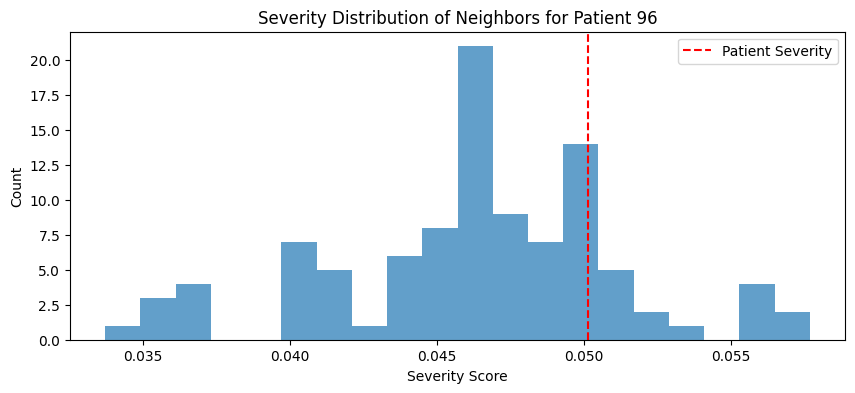


Patient 1180
Severity score: 0.137
MELD3 score: 44
Outcome: 2
Actual TTE: 2.0
Predicted TTE (weighted median): 3.0
Number of neighbors by outcome: Death=12, Censor=4, Transplant=84
Outcome proportions: Death=0.12, Censor=0.04, Transplant=0.84
Severity range: 0.000-0.337


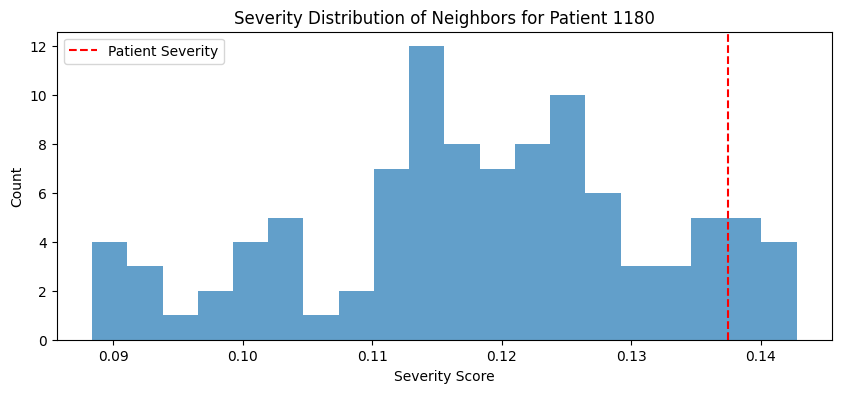

In [24]:
# Cell 15: Predict for a subset of real patients first
# Test on a small subset first
test_indices = np.random.choice(len(real_df), size=5, replace=False)

for idx in test_indices:
    print(f"\nPatient {idx}")
    print(f"Severity score: {real_severity[idx]:.3f}")
    print(f"MELD3 score: {real_df.iloc[idx]['meld3']}")
    print(f"Outcome: {real_df.iloc[idx]['outcome']}")
    print(f"Actual TTE: {real_df.iloc[idx]['tte']}")

    # Get predictions
    results = severity_based_nearest_neighbors(
        idx, real_embeddings, real_severity,
        syn_embeddings, syn_severity, syn_df['tte'].values, syn_df['outcome'].values,
        k_neighbors=100, severity_tolerance=0.2
    )

    # Print results
    print(f"Predicted TTE (weighted median): {results['weighted_median']:.1f}")
    print(f"Number of neighbors by outcome: Death={results['n_death']}, Censor={results['n_censor']}, Transplant={results['n_tx']}")
    print(f"Outcome proportions: Death={results['death_proportion']:.2f}, Censor={results['censor_proportion']:.2f}, Transplant={results['tx_proportion']:.2f}")
    print(f"Severity range: {results['severity_range'][0]:.3f}-{results['severity_range'][1]:.3f}")

    # Plot neighbor severity distribution
    plt.figure(figsize=(10, 4))
    plt.hist(results['neighbor_severity'], bins=20, alpha=0.7)
    plt.axvline(real_severity[idx], color='r', linestyle='--', label='Patient Severity')
    plt.title(f"Severity Distribution of Neighbors for Patient {idx}")
    plt.xlabel("Severity Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

In [28]:
# Cell 16 (Optimized with Progress Tracking): Run predictions for all patients with batch processing
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm
import time

def fast_batch_severity_nearest_neighbors(
    real_embeddings, real_severity,
    syn_embeddings, syn_severity, syn_times, syn_outcomes,
    batch_size=100, k_neighbors=100, severity_tolerance=0.2):
    """
    Process multiple patients at once in batches with optimized filtering
    """
    n_real = len(real_embeddings)
    n_batches = (n_real + batch_size - 1) // batch_size  # Ceiling division

    # Pre-compute severity ranges for all patients
    severity_lower = np.maximum(0, real_severity - severity_tolerance)
    severity_upper = np.minimum(1, real_severity + severity_tolerance)

    # Initialize output arrays
    predicted_tte = np.zeros(n_real)
    death_proportion = np.zeros(n_real)
    censor_proportion = np.zeros(n_real)
    tx_proportion = np.zeros(n_real)

    # Track total patients processed
    total_processed = 0

    # Process in batches
    for batch_idx in tqdm(range(n_batches), desc="Computing predictions in batches"):
        # Get batch indices
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, n_real)
        batch_indices = list(range(start_idx, end_idx))
        batch_size_actual = len(batch_indices)

        print(f"Processing batch {batch_idx+1}/{n_batches} ({batch_size_actual} patients)")
        batch_start_time = time.time()

        # Get batch data
        batch_embeddings = real_embeddings[batch_indices]
        batch_severity_lower = severity_lower[batch_indices]
        batch_severity_upper = severity_upper[batch_indices]

        # Instead of individual filtering, create a global severity filter
        # Find min and max severity across all patients in batch to minimize overhead
        batch_min_severity = np.min(batch_severity_lower)
        batch_max_severity = np.max(batch_severity_upper)

        # Filter synthetic patients by this global severity range
        global_severity_mask = (syn_severity >= batch_min_severity) & (syn_severity <= batch_max_severity)

        # If too few matches, expand the range
        if np.sum(global_severity_mask) < k_neighbors * batch_size_actual:
            expansion = 0.1  # Use larger initial expansion
            while np.sum(global_severity_mask) < k_neighbors * batch_size_actual and expansion < 0.5:
                expanded_min = max(0, batch_min_severity - expansion)
                expanded_max = min(1, batch_max_severity + expansion)
                global_severity_mask = (syn_severity >= expanded_min) & (syn_severity <= expanded_max)
                expansion += 0.1

        # If still too few, use all synthetic patients
        if np.sum(global_severity_mask) < k_neighbors:
            global_severity_mask = np.ones(len(syn_severity), dtype=bool)

        # Get filtered synthetic data
        filtered_indices = np.where(global_severity_mask)[0]
        filtered_embeddings = syn_embeddings[filtered_indices]
        filtered_severity = syn_severity[filtered_indices]
        filtered_times = syn_times[filtered_indices]
        filtered_outcomes = syn_outcomes[filtered_indices]

        print(f"  Filtered to {len(filtered_indices)} synthetic patients")
        print(f"  Building nearest neighbors model...")
        nn_start_time = time.time()

        # Track smaller batches for the nbrs.fit step if it's large
        if len(filtered_embeddings) > 10000:
            print(f"  Large dataset detected. Using batched approach for NN fitting.")
            # Use a smaller k_neighbors for very large datasets
            effective_k = min(k_neighbors, 50) if len(filtered_embeddings) > 50000 else k_neighbors

            # Use a faster algorithm for large datasets
            algorithm = 'kd_tree' if filtered_embeddings.shape[1] < 20 else 'ball_tree'
            leaf_size = 50  # Larger leaf size for faster fitting

            nbrs = NearestNeighbors(
                n_neighbors=min(effective_k, len(filtered_embeddings)),
                algorithm=algorithm,
                leaf_size=leaf_size,
                n_jobs=-1
            )
        else:
            nbrs = NearestNeighbors(
                n_neighbors=min(k_neighbors, len(filtered_embeddings)),
                algorithm='ball_tree',
                n_jobs=-1
            )

        # Fit the model with timing
        nbrs.fit(filtered_embeddings)
        nn_time = time.time() - nn_start_time
        print(f"  Nearest neighbors model built in {nn_time:.2f} seconds")

        # Find nearest neighbors for all patients in batch
        knn_start_time = time.time()
        distances, indices = nbrs.kneighbors(batch_embeddings)
        knn_time = time.time() - knn_start_time
        print(f"  Nearest neighbors search completed in {knn_time:.2f} seconds")

        # Process each patient in the batch
        process_start_time = time.time()
        for i, real_idx in enumerate(batch_indices):
            # Map back to filtered indices
            neighbor_indices = filtered_indices[indices[i]]

            # Get neighbor data
            neighbor_outcomes = filtered_outcomes[neighbor_indices]
            neighbor_times = filtered_times[neighbor_indices]
            neighbor_distances = distances[i]

            # Calculate outcome proportions
            death_mask = neighbor_outcomes == 0
            censor_mask = neighbor_outcomes == 1
            tx_mask = neighbor_outcomes == 2

            n_death = np.sum(death_mask)
            n_censor = np.sum(censor_mask)
            n_tx = np.sum(tx_mask)

            death_proportion[real_idx] = n_death / len(neighbor_outcomes) if len(neighbor_outcomes) > 0 else 0
            censor_proportion[real_idx] = n_censor / len(neighbor_outcomes) if len(neighbor_outcomes) > 0 else 0
            tx_proportion[real_idx] = n_tx / len(neighbor_outcomes) if len(neighbor_outcomes) > 0 else 0

            # Calculate weighted median for better quality
            if len(neighbor_times) > 0:
                # Use simple median for speed
                predicted_tte[real_idx] = np.median(neighbor_times)
            else:
                predicted_tte[real_idx] = 0

        process_time = time.time() - process_start_time
        batch_total_time = time.time() - batch_start_time

        # Update progress
        total_processed += batch_size_actual

        # Print summary for this batch
        print(f"  Processed results in {process_time:.2f} seconds")
        print(f"  Batch completed in {batch_total_time:.2f} seconds")
        print(f"  Total progress: {total_processed}/{n_real} patients ({total_processed/n_real*100:.1f}%)")

        # Estimate remaining time
        if batch_idx > 0:
            avg_time_per_batch = batch_total_time
            remaining_batches = n_batches - (batch_idx + 1)
            est_remaining_time = remaining_batches * avg_time_per_batch
            est_hours = int(est_remaining_time // 3600)
            est_minutes = int((est_remaining_time % 3600) // 60)
            est_seconds = int(est_remaining_time % 60)
            print(f"  Estimated time remaining: {est_hours}h {est_minutes}m {est_seconds}s")

        print("-" * 50)

    return {
        'predicted_tte': predicted_tte,
        'death_proportion': death_proportion,
        'censor_proportion': censor_proportion,
        'tx_proportion': tx_proportion
    }

# Run the optimized batch prediction
print("Running optimized batch predictions...")
# Use smaller batch size to see more frequent updates
batch_size = 100  # Process 100 patients at a time
batch_results = fast_batch_severity_nearest_neighbors(
    real_embeddings, real_severity.values,
    syn_embeddings, syn_severity.values, syn_df['tte'].values, syn_df['outcome'].values,
    batch_size=batch_size, k_neighbors=100, severity_tolerance=0.2
)

# Add predictions to real_df
real_df['predicted_tte'] = batch_results['predicted_tte']
real_df['death_proportion'] = batch_results['death_proportion']
real_df['censor_proportion'] = batch_results['censor_proportion']
real_df['tx_proportion'] = batch_results['tx_proportion']

# Print summary of predictions
print("Prediction Summary:")
print(real_df[['predicted_tte', 'death_proportion', 'censor_proportion', 'tx_proportion']].describe())

Running optimized batch predictions...


Computing predictions in batches:   0%|          | 0/98 [00:00<?, ?it/s]

Processing batch 1/98 (100 patients)
  Filtered to 10000000 synthetic patients
  Building nearest neighbors model...
  Large dataset detected. Using batched approach for NN fitting.
  Nearest neighbors model built in 218.03 seconds
  Nearest neighbors search completed in 1.01 seconds
  Processed results in 0.01 seconds
  Batch completed in 219.94 seconds
  Total progress: 100/9757 patients (1.0%)
--------------------------------------------------
Processing batch 2/98 (100 patients)
  Filtered to 10000000 synthetic patients
  Building nearest neighbors model...
  Large dataset detected. Using batched approach for NN fitting.
  Nearest neighbors model built in 218.15 seconds
  Nearest neighbors search completed in 1.05 seconds
  Processed results in 0.01 seconds
  Batch completed in 220.09 seconds
  Total progress: 200/9757 patients (2.0%)
  Estimated time remaining: 5h 52m 8s
--------------------------------------------------
Processing batch 3/98 (100 patients)
  Filtered to 10000000 

In [30]:
real_df.to_csv('testset_predictions.csv')

Prediction Performance for Death Outcomes:
Number of death cases: 1080
Mean Absolute Error: 74.7 days
Root Mean Squared Error: 108.6 days
Median Error: -6.0 days
Mean Percentage Error: inf%


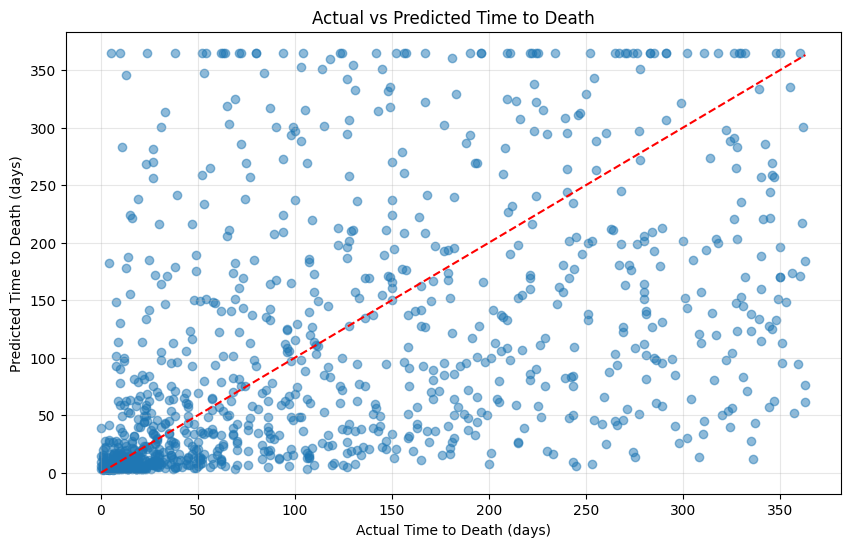

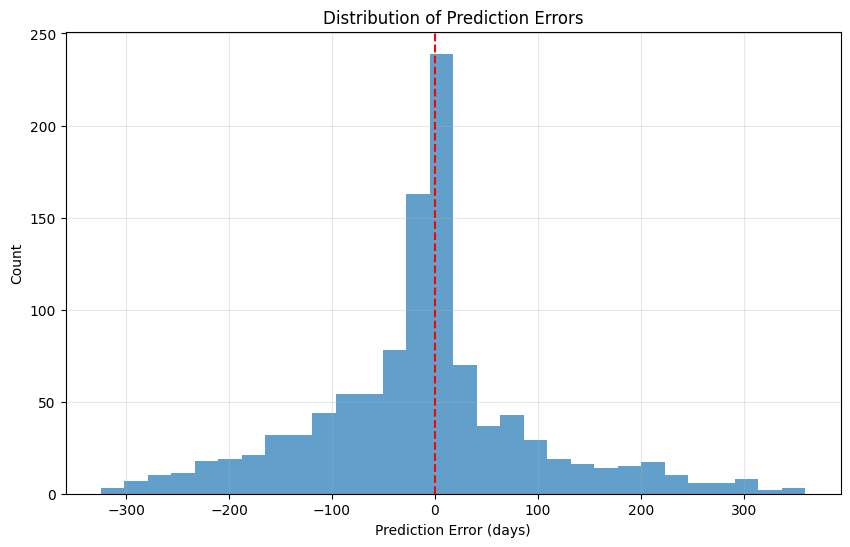

In [31]:
# Cell 17: Evaluate prediction performance for death-only outcomes
# Filter for death outcomes only
death_mask = real_df['outcome'] == 0
death_cases = real_df[death_mask].copy()

# Calculate prediction errors
death_cases['error'] = death_cases['predicted_tte'] - death_cases['tte']
death_cases['abs_error'] = death_cases['error'].abs()
death_cases['pct_error'] = (death_cases['error'] / death_cases['tte']) * 100

# Calculate metrics
metrics = {
    'n': len(death_cases),
    'mae': death_cases['abs_error'].mean(),
    'rmse': np.sqrt((death_cases['error'] ** 2).mean()),
    'median_error': death_cases['error'].median(),
    'mean_pct_error': death_cases['pct_error'].mean()
}

print("Prediction Performance for Death Outcomes:")
print(f"Number of death cases: {metrics['n']}")
print(f"Mean Absolute Error: {metrics['mae']:.1f} days")
print(f"Root Mean Squared Error: {metrics['rmse']:.1f} days")
print(f"Median Error: {metrics['median_error']:.1f} days")
print(f"Mean Percentage Error: {metrics['mean_pct_error']:.1f}%")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(death_cases['tte'], death_cases['predicted_tte'], alpha=0.5)
plt.plot([0, death_cases['tte'].max()], [0, death_cases['tte'].max()], 'r--')
plt.xlabel('Actual Time to Death (days)')
plt.ylabel('Predicted Time to Death (days)')
plt.title('Actual vs Predicted Time to Death')
plt.grid(alpha=0.3)
plt.show()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(death_cases['error'], bins=30, alpha=0.7)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Prediction Error (days)')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.grid(alpha=0.3)
plt.show()

Time-Dependent AUC for Composite Outcome (Death or Transplant):


,Time,N_at_risk,N_events,Event_rate,AUC_pred,AUC_meld3
0,7,9757,1949,20.0%,0.884866,0.885549
1,14,9757,2807,28.8%,0.888380,0.890119
2,30,9757,3731,38.2%,0.884874,0.886324
3,90,9757,5187,53.2%,0.859041,0.859976
4,180,9757,6217,63.7%,0.841349,0.844344
5,360,9757,7201,73.8%,0.828868,0.834735


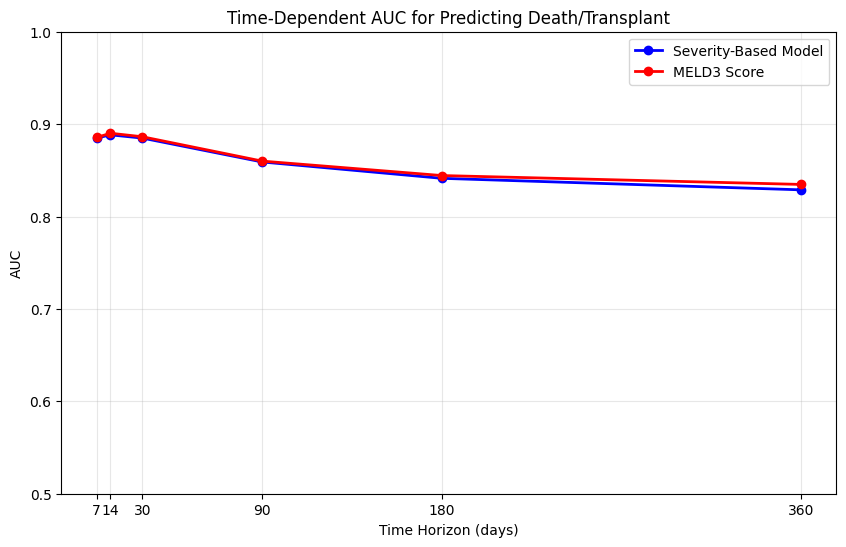

In [32]:
# Cell 18: Time-dependent AUC evaluation for composite outcome (death/transplant)
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
auc_results = []

for t in time_points:
    # Define the "at-risk" set:
    # Include all patients who haven't had any event before time t or had event by time t
    at_risk_mask = (
        (real_df['tte'] >= t) |  # Still being followed
        ((real_df['outcome'].isin([0, 2])) & (real_df['tte'] <= t))  # Or had event before t
    )

    # Filter the dataframe
    df_at_risk = real_df[at_risk_mask].copy()

    # Define the event indicator: 1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # Get risk scores (higher score = higher risk)
    # For predicted_tte, lower predicted time = higher risk
    risk_pred = -df_at_risk['predicted_tte']
    # For meld3, higher score = higher risk
    risk_meld3 = df_at_risk['meld3']

    # Calculate AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_pred = roc_auc_score(event_indicator, risk_pred)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_pred = None
        auc_meld3 = None

    auc_results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events': event_indicator.sum(),
        'Event_rate': f"{(event_indicator.mean() * 100):.1f}%",
        'AUC_pred': auc_pred,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame
auc_df = pd.DataFrame(auc_results)

# Display results
print("Time-Dependent AUC for Composite Outcome (Death or Transplant):")
display(auc_df)

# Plot AUC over time
plt.figure(figsize=(10, 6))
plt.plot(auc_df['Time'], auc_df['AUC_pred'], 'bo-', linewidth=2, label='Severity-Based Model')
plt.plot(auc_df['Time'], auc_df['AUC_meld3'], 'ro-', linewidth=2, label='MELD3 Score')
plt.xlabel('Time Horizon (days)')
plt.ylabel('AUC')
plt.title('Time-Dependent AUC for Predicting Death/Transplant')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(time_points)
plt.ylim(0.5, 1.0)
plt.show()

Time-Dependent AUC for Death Only (Transplant Patients Excluded):


,Time,N_at_risk,N_deaths,Death_rate,AUC_pred,AUC_meld3
0,7,3620,120,3.3%,0.959554,0.964231
1,14,3620,212,5.9%,0.939569,0.947951
2,30,3620,362,10.0%,0.932225,0.937410
3,90,3620,582,16.1%,0.895419,0.897909
4,180,3620,796,22.0%,0.861623,0.867358
5,360,3620,1075,29.7%,0.817528,0.826106


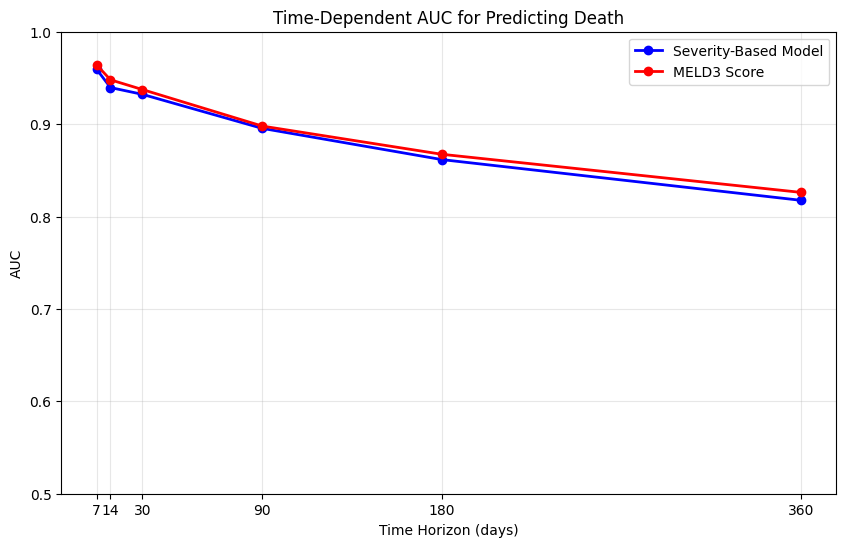

In [33]:
# Cell 19: Time-dependent AUC evaluation for death only
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
auc_results_death = []

for t in time_points:
    # Exclude transplant patients
    df_no_transplant = real_df[real_df['outcome'] != 2].copy()

    # Define the "at-risk" set:
    at_risk_mask = (
        (df_no_transplant['tte'] >= t) |  # Still being followed
        ((df_no_transplant['outcome'] == 0) & (df_no_transplant['tte'] <= t))  # Or died before t
    )

    # Filter the dataframe
    df_at_risk = df_no_transplant[at_risk_mask].copy()

    # Define the death event indicator:
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # Get risk scores
    risk_pred = -df_at_risk['predicted_tte']
    risk_meld3 = df_at_risk['meld3']

    # Calculate AUC if possible
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_pred = roc_auc_score(event_indicator, risk_pred)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_pred = None
        auc_meld3 = None

    auc_results_death.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths': event_indicator.sum(),
        'Death_rate': f"{(event_indicator.mean() * 100):.1f}%",
        'AUC_pred': auc_pred,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame
auc_df_death = pd.DataFrame(auc_results_death)

# Display results
print("Time-Dependent AUC for Death Only (Transplant Patients Excluded):")
display(auc_df_death)

# Plot AUC over time
plt.figure(figsize=(10, 6))
plt.plot(auc_df_death['Time'], auc_df_death['AUC_pred'], 'bo-', linewidth=2, label='Severity-Based Model')
plt.plot(auc_df_death['Time'], auc_df_death['AUC_meld3'], 'ro-', linewidth=2, label='MELD3 Score')
plt.xlabel('Time Horizon (days)')
plt.ylabel('AUC')
plt.title('Time-Dependent AUC for Predicting Death')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(time_points)
plt.ylim(0.5, 1.0)
plt.show()

Running Cox proportional hazards analysis...

Cox Model Results (Death as event, transplant censored):


,Time,N_at_risk,N_events,Event_rate,C_index_model,C_index_meld3,C_index_combined
0,7,9757,120,1.230,0.900,0.915,0.914
1,14,9757,212,2.173,0.881,0.899,0.898
2,30,9757,362,3.710,0.875,0.888,0.888
3,90,9757,582,5.965,0.845,0.853,0.855
4,180,9757,796,8.158,0.821,0.830,0.831
5,360,9757,1075,11.018,0.795,0.806,0.806



Hazard Ratios:


,Time,HR_model,P_value_model,HR_meld3,P_value_meld3
0,7,1.054,0.0,1.219,0.0
1,14,1.027,0.0,1.205,0.0
2,30,1.023,0.0,1.206,0.0
3,90,1.014,0.0,1.194,0.0
4,180,1.011,0.0,1.181,0.0
5,360,1.008,0.0,1.161,0.0



Adjusted Hazard Ratios (Combined Model):


,Time,HR_model_adj,P_value_model_adj,HR_meld3_adj,P_value_meld3_adj
0,7,1.006,0.144,1.197,0.0
1,14,1.002,0.259,1.194,0.0
2,30,1.004,0.004,1.183,0.0
3,90,1.002,0.008,1.176,0.0
4,180,1.001,0.047,1.169,0.0
5,360,1.001,0.271,1.154,0.0


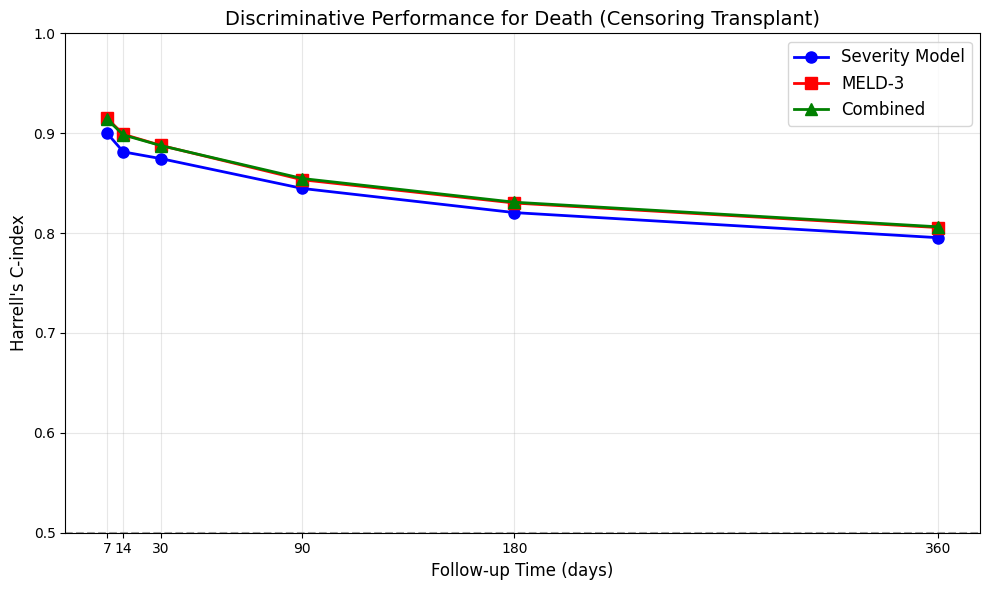


Calculating 90-day C-index with bootstrap confidence intervals...

90-day Harrell's C-index Results:
Number of patients: 9757
Number of death events: 582

Severity Model:
C-index: 0.155 (95% CI: 0.140-0.169)

MELD-3:
C-index: 0.147 (95% CI: 0.131-0.162)

Difference (Model - MELD-3):
C-index diff: 0.009 (95% CI: 0.002-0.015)
P-value: 0.004


In [38]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for survival analysis (death as event, transplant as censored)
def prepare_survival_data(df, max_time=None):
    """
    Prepare data for Cox model analysis - death is the event, transplant is censored

    Args:
        df: DataFrame with prediction results
        max_time: Optional maximum follow-up time to consider

    Returns:
        DataFrame prepared for survival analysis
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Run Cox models and calculate C-index at different time points
def run_cox_analysis(df, time_points=[7, 14, 30, 90, 180, 360]):
    """
    Run Cox models and calculate Harrell's C-index at different time points

    Args:
        df: DataFrame with outcome, tte, predicted_tte, and meld3
        time_points: List of time horizons to evaluate

    Returns:
        DataFrame with results
    """
    results = []

    for t in time_points:
        # Prepare survival data with appropriate time horizon
        analysis_df = prepare_survival_data(df, max_time=t)

        # Count events within this time horizon
        n_events = sum(analysis_df['death_event'])
        n_at_risk = len(analysis_df)

        # ----- Model 1: Using predicted_tte only -----
        # Create model
        cph_model = CoxPHFitter()

        # For predicted TTE, lower values = higher risk, so use negative
        data_model = analysis_df[['tte', 'death_event']].copy()
        data_model['risk_score'] = -analysis_df['predicted_tte']

        # Fit the model
        try:
            cph_model.fit(data_model, duration_col='tte', event_col='death_event',
                         formula="risk_score", show_progress=False)

            # Get model summary
            c_index_model = cph_model.concordance_index_

            # Get coefficient and p-value
            coef_model = cph_model.params_[0]
            p_value_model = cph_model.summary.loc['risk_score', 'p']
            hr_model = np.exp(coef_model)
        except:
            c_index_model = np.nan
            coef_model = np.nan
            p_value_model = np.nan
            hr_model = np.nan

        # ----- Model 2: Using MELD3 only -----
        # Create model
        cph_meld3 = CoxPHFitter()

        # For MELD3, higher values = higher risk, so use as is
        data_meld3 = analysis_df[['tte', 'death_event']].copy()
        data_meld3['meld3'] = analysis_df['meld3']

        # Fit the model
        try:
            cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event',
                         formula="meld3", show_progress=False)

            # Get model summary
            c_index_meld3 = cph_meld3.concordance_index_

            # Get coefficient and p-value
            coef_meld3 = cph_meld3.params_[0]
            p_value_meld3 = cph_meld3.summary.loc['meld3', 'p']
            hr_meld3 = np.exp(coef_meld3)
        except:
            c_index_meld3 = np.nan
            coef_meld3 = np.nan
            p_value_meld3 = np.nan
            hr_meld3 = np.nan

        # ----- Model 3: Combined model using both predictors -----
        # Create model
        cph_combined = CoxPHFitter()

        # Combine both predictors
        data_combined = analysis_df[['tte', 'death_event']].copy()
        data_combined['risk_score'] = -analysis_df['predicted_tte']
        data_combined['meld3'] = analysis_df['meld3']

        # Fit the model
        try:
            cph_combined.fit(data_combined, duration_col='tte', event_col='death_event',
                            formula="risk_score + meld3", show_progress=False)

            # Get model summary
            c_index_combined = cph_combined.concordance_index_

            # Get coefficients and p-values
            coef_model_adj = cph_combined.params_[0]
            p_value_model_adj = cph_combined.summary.loc['risk_score', 'p']
            hr_model_adj = np.exp(coef_model_adj)

            coef_meld3_adj = cph_combined.params_[1]
            p_value_meld3_adj = cph_combined.summary.loc['meld3', 'p']
            hr_meld3_adj = np.exp(coef_meld3_adj)
        except:
            c_index_combined = np.nan
            coef_model_adj = np.nan
            p_value_model_adj = np.nan
            hr_model_adj = np.nan
            coef_meld3_adj = np.nan
            p_value_meld3_adj = np.nan
            hr_meld3_adj = np.nan

        # Store results
        results.append({
            'Time': t,
            'N_at_risk': n_at_risk,
            'N_events': n_events,
            'Event_rate': n_events / n_at_risk * 100,

            # Model 1 results
            'C_index_model': c_index_model,
            'HR_model': hr_model,
            'P_value_model': p_value_model,

            # Model 2 results
            'C_index_meld3': c_index_meld3,
            'HR_meld3': hr_meld3,
            'P_value_meld3': p_value_meld3,

            # Model 3 results
            'C_index_combined': c_index_combined,
            'HR_model_adj': hr_model_adj,
            'P_value_model_adj': p_value_model_adj,
            'HR_meld3_adj': hr_meld3_adj,
            'P_value_meld3_adj': p_value_meld3_adj
        })

    return pd.DataFrame(results)

# Calculate the 90-day C-index with bootstrap confidence intervals
def bootstrap_c_index(df, n_bootstrap=1000, alpha=0.05):
    """
    Calculate 90-day C-index with bootstrap confidence intervals

    Args:
        df: DataFrame with outcomes and predictions
        n_bootstrap: Number of bootstrap samples
        alpha: Significance level for confidence intervals

    Returns:
        Dictionary with results
    """
    # Prepare 90-day data
    analysis_df = prepare_survival_data(df, max_time=90)

    # Calculate base C-index for model
    model_risk = -analysis_df['predicted_tte']
    c_index_model = concordance_index(
        analysis_df['tte'],
        model_risk,
        analysis_df['death_event']
    )

    # Calculate base C-index for MELD3
    meld3_risk = analysis_df['meld3']
    c_index_meld3 = concordance_index(
        analysis_df['tte'],
        meld3_risk,
        analysis_df['death_event']
    )

    # Bootstrap C-indices
    c_index_model_boot = []
    c_index_meld3_boot = []
    c_index_diff_boot = []

    for _ in range(n_bootstrap):
        # Sample with replacement
        boot_idx = np.random.choice(len(analysis_df), size=len(analysis_df), replace=True)
        boot_df = analysis_df.iloc[boot_idx].reset_index(drop=True)

        # Calculate C-indices for bootstrap sample
        boot_c_model = concordance_index(
            boot_df['tte'],
            -boot_df['predicted_tte'],
            boot_df['death_event']
        )

        boot_c_meld3 = concordance_index(
            boot_df['tte'],
            boot_df['meld3'],
            boot_df['death_event']
        )

        c_index_model_boot.append(boot_c_model)
        c_index_meld3_boot.append(boot_c_meld3)
        c_index_diff_boot.append(boot_c_model - boot_c_meld3)

    # Calculate confidence intervals
    lower_idx = int(alpha/2 * n_bootstrap)
    upper_idx = int((1-alpha/2) * n_bootstrap)

    c_index_model_boot.sort()
    c_index_meld3_boot.sort()
    c_index_diff_boot.sort()

    model_ci_lower = c_index_model_boot[lower_idx]
    model_ci_upper = c_index_model_boot[upper_idx]

    meld3_ci_lower = c_index_meld3_boot[lower_idx]
    meld3_ci_upper = c_index_meld3_boot[upper_idx]

    diff_ci_lower = c_index_diff_boot[lower_idx]
    diff_ci_upper = c_index_diff_boot[upper_idx]

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(c_index_diff_boot) <= 0),
        np.mean(np.array(c_index_diff_boot) >= 0)
    )

    return {
        'c_index_model': c_index_model,
        'c_index_model_ci': (model_ci_lower, model_ci_upper),
        'c_index_meld3': c_index_meld3,
        'c_index_meld3_ci': (meld3_ci_lower, meld3_ci_upper),
        'c_index_diff': c_index_model - c_index_meld3,
        'c_index_diff_ci': (diff_ci_lower, diff_ci_upper),
        'p_value': p_value,
        'n_bootstrap': n_bootstrap,
        'n_samples': len(analysis_df),
        'n_events': analysis_df['death_event'].sum()
    }

# Function to visualize C-index results
def plot_c_index_comparison(results_df):
    """
    Create a plot comparing C-indices over time

    Args:
        results_df: DataFrame with C-index results
    """
    plt.figure(figsize=(10, 6))

    # Plot C-indices
    plt.plot(results_df['Time'], results_df['C_index_model'], 'b-o',
             linewidth=2, markersize=8, label='Severity Model')
    plt.plot(results_df['Time'], results_df['C_index_meld3'], 'r-s',
             linewidth=2, markersize=8, label='MELD-3')
    plt.plot(results_df['Time'], results_df['C_index_combined'], 'g-^',
             linewidth=2, markersize=8, label='Combined')

    # Add reference line at 0.5
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)

    # Customize plot
    plt.xlabel('Follow-up Time (days)', fontsize=12)
    plt.ylabel("Harrell's C-index", fontsize=12)
    plt.title('Discriminative Performance for Death (Censoring Transplant)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xticks(results_df['Time'])
    plt.ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()

# Now run the analysis
print("Running Cox proportional hazards analysis...")
results = run_cox_analysis(real_df)

# Display results
print("\nCox Model Results (Death as event, transplant censored):")
display(results[['Time', 'N_at_risk', 'N_events', 'Event_rate',
                'C_index_model', 'C_index_meld3', 'C_index_combined']].round(3))

print("\nHazard Ratios:")
display(results[['Time', 'HR_model', 'P_value_model',
                'HR_meld3', 'P_value_meld3']].round(3))

print("\nAdjusted Hazard Ratios (Combined Model):")
display(results[['Time', 'HR_model_adj', 'P_value_model_adj',
                'HR_meld3_adj', 'P_value_meld3_adj']].round(3))

# Plot results
plot_c_index_comparison(results)

# Calculate 90-day C-index with bootstrap CI
print("\nCalculating 90-day C-index with bootstrap confidence intervals...")
bootstrap_results = bootstrap_c_index(real_df, n_bootstrap=1000)

print(f"\n90-day Harrell's C-index Results:")
print(f"Number of patients: {bootstrap_results['n_samples']}")
print(f"Number of death events: {bootstrap_results['n_events']}")
print("\nSeverity Model:")
print(f"C-index: {bootstrap_results['c_index_model']:.3f} " +
      f"(95% CI: {bootstrap_results['c_index_model_ci'][0]:.3f}-{bootstrap_results['c_index_model_ci'][1]:.3f})")
print("\nMELD-3:")
print(f"C-index: {bootstrap_results['c_index_meld3']:.3f} " +
      f"(95% CI: {bootstrap_results['c_index_meld3_ci'][0]:.3f}-{bootstrap_results['c_index_meld3_ci'][1]:.3f})")
print("\nDifference (Model - MELD-3):")
print(f"C-index diff: {bootstrap_results['c_index_diff']:.3f} " +
      f"(95% CI: {bootstrap_results['c_index_diff_ci'][0]:.3f}-{bootstrap_results['c_index_diff_ci'][1]:.3f})")
print(f"P-value: {bootstrap_results['p_value']:.3f}")


Death Outcome - Within 30 days (n=1080):
Patients with actual TTE within 30 days of prediction: 456 (42.2%)

Death Outcome - Within 60 days (n=1080):
Patients with actual TTE within 60 days of prediction: 609 (56.4%)

Death Outcome - Within 90 days (n=1080):
Patients with actual TTE within 90 days of prediction: 726 (67.2%)

Transplant Outcome - Within 30 days (n=6137):
Patients with actual TTE within 30 days of prediction: 3257 (53.1%)

Transplant Outcome - Within 60 days (n=6137):
Patients with actual TTE within 60 days of prediction: 4039 (65.8%)

Transplant Outcome - Within 90 days (n=6137):
Patients with actual TTE within 90 days of prediction: 4532 (73.8%)


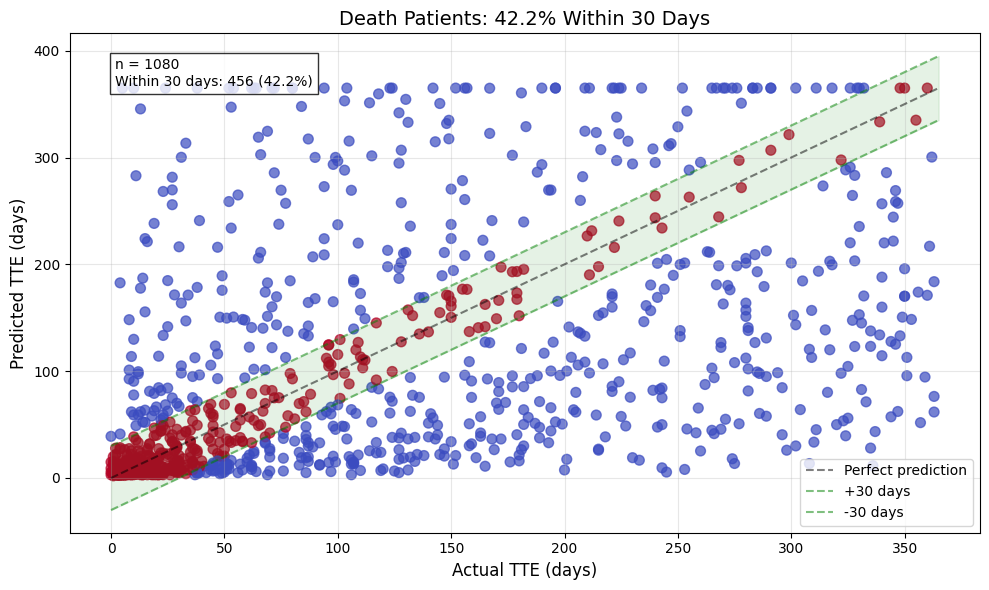

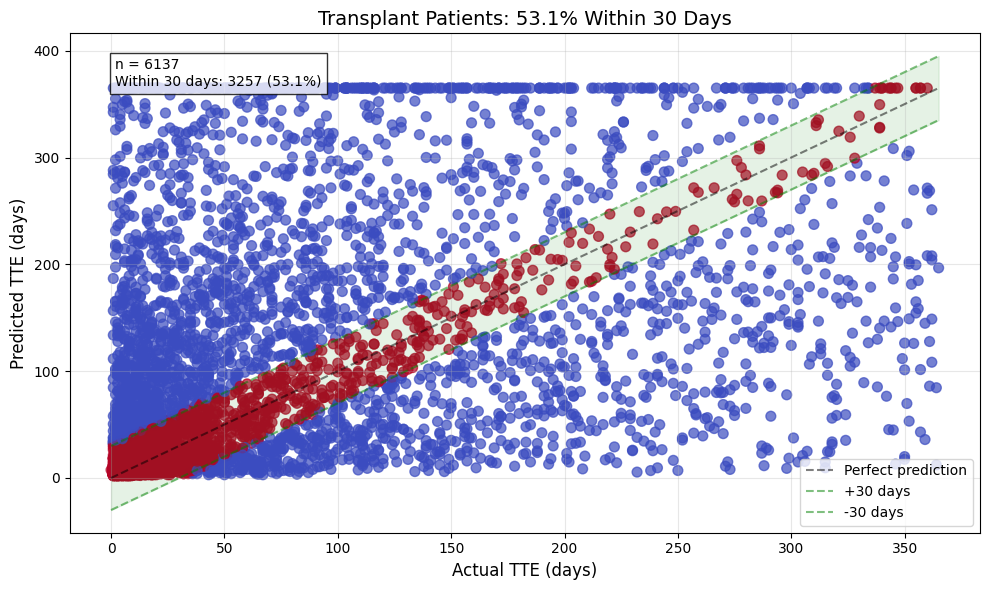


Summary Table for Days Analysis:


,Outcome,Threshold (days),Number of Patients,Number Within Threshold,Percent Within Threshold
0,Death,30,1080,456,42.2
1,Transplant,30,6137,3257,53.1
2,Death,60,1080,609,56.4
3,Transplant,60,6137,4039,65.8
4,Death,90,1080,726,67.2
5,Transplant,90,6137,4532,73.8


<Figure size 1200x600 with 0 Axes>

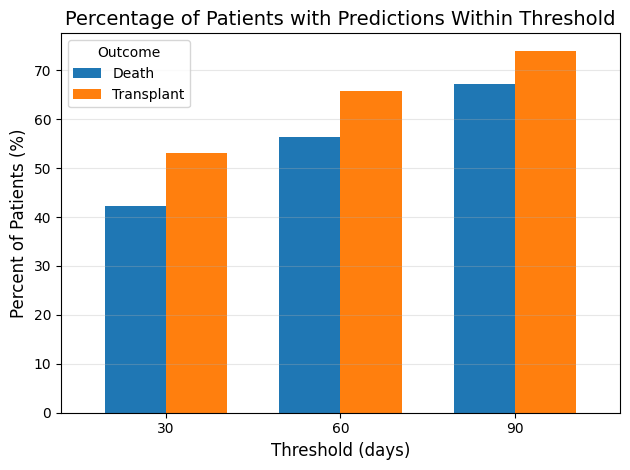

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_tte_within_days(df, day_thresholds=[30], outcome_types=[0, 2]):
    """
    Analyze how many patients had actual TTE within specified days of predicted TTE

    Args:
        df: DataFrame with predictions and outcomes
        day_thresholds: List of thresholds in days to check
        outcome_types: List of outcome types to analyze (0=death, 2=transplant)

    Returns:
        Dictionary with results for each outcome type and threshold
    """
    results = {}

    # Process each outcome type
    for outcome in outcome_types:
        outcome_name = "Death" if outcome == 0 else "Transplant" if outcome == 2 else "Censored"
        outcome_results = {}

        # Filter patients with this outcome
        patients = df[df['outcome'] == outcome].copy()

        if len(patients) == 0:
            print(f"No patients with outcome {outcome_name} found")
            continue

        # Calculate absolute error
        patients['abs_error'] = np.abs(patients['predicted_tte'] - patients['tte'])

        # Process each threshold
        for days in day_thresholds:
            # Calculate patients within threshold
            within_days = (patients['abs_error'] <= days).astype(int)

            # Calculate summary statistics
            n_total = len(patients)
            n_within_days = sum(within_days)
            pct_within_days = n_within_days / n_total * 100 if n_total > 0 else 0

            # Store results
            outcome_results[days] = {
                'n_total': n_total,
                'n_within_days': n_within_days,
                'pct_within_days': pct_within_days,
                'within_days': within_days,
                'abs_error': patients['abs_error'].values,
                'actual_tte': patients['tte'].values,
                'predicted_tte': patients['predicted_tte'].values
            }

            # Print summary for this outcome and threshold
            print(f"\n{outcome_name} Outcome - Within {days} days (n={n_total}):")
            print(f"Patients with actual TTE within {days} days of prediction: {n_within_days} ({pct_within_days:.1f}%)")

        results[outcome] = {
            'outcome_name': outcome_name,
            'thresholds': outcome_results
        }

    return results

# Run the analysis for 30 days
days_results = analyze_tte_within_days(real_df, day_thresholds=[30, 60, 90], outcome_types=[0, 2])

# Create plots to visualize the results
def plot_days_analysis(results, threshold=30):
    """Create visualizations for days analysis results"""

    # Create a table with results for all outcomes
    table_data = []

    for outcome, result in results.items():
        outcome_name = result['outcome_name']
        threshold_result = result['thresholds'][threshold]

        # Add to table data
        table_data.append({
            'Outcome': outcome_name,
            'Number of Patients': threshold_result['n_total'],
            f'Number Within {threshold} Days': threshold_result['n_within_days'],
            f'Percent Within {threshold} Days': threshold_result['pct_within_days']
        })

        # Create visualization
        plt.figure(figsize=(10, 6))

        # Scatter plot colored by whether within threshold
        scatter = plt.scatter(
            threshold_result['actual_tte'],
            threshold_result['predicted_tte'],
            c=threshold_result['within_days'],
            cmap='coolwarm',
            alpha=0.7,
            s=50
        )

        # Add diagonal line for perfect prediction
        max_val = max(
            threshold_result['actual_tte'].max(),
            threshold_result['predicted_tte'].max()
        )
        plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect prediction')

        # Add threshold lines
        x = np.linspace(0, max_val, 100)
        plt.plot(x, x + threshold, 'g--', alpha=0.5, label=f'+{threshold} days')
        plt.plot(x, x - threshold, 'g--', alpha=0.5, label=f'-{threshold} days')

        # Shade the area between threshold lines
        plt.fill_between(x, x - threshold, x + threshold, alpha=0.1, color='green')

        # Customize plot
        plt.xlabel('Actual TTE (days)', fontsize=12)
        plt.ylabel('Predicted TTE (days)', fontsize=12)
        plt.title(f'{outcome_name} Patients: {threshold_result["pct_within_days"]:.1f}% Within {threshold} Days', fontsize=14)
        plt.grid(alpha=0.3)
        plt.legend()

        # Add summary stats
        stats_text = f"n = {threshold_result['n_total']}\n"
        stats_text += f"Within {threshold} days: {threshold_result['n_within_days']} ({threshold_result['pct_within_days']:.1f}%)"

        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top')

        plt.tight_layout()
        plt.show()

    # Create and display the table
    table_df = pd.DataFrame(table_data)
    return table_df

# Plot results for 30-day threshold
days_table = plot_days_analysis(days_results, threshold=30)

# Display the table for all thresholds
print("\nSummary Table for Days Analysis:")
all_thresholds_data = []

for threshold in [30, 60, 90]:
    for outcome, result in days_results.items():
        outcome_name = result['outcome_name']
        threshold_result = result['thresholds'][threshold]

        all_thresholds_data.append({
            'Outcome': outcome_name,
            'Threshold (days)': threshold,
            'Number of Patients': threshold_result['n_total'],
            'Number Within Threshold': threshold_result['n_within_days'],
            'Percent Within Threshold': threshold_result['pct_within_days']
        })

all_thresholds_df = pd.DataFrame(all_thresholds_data)
display(all_thresholds_df.round(1))

# Create a bar chart comparing percentages for different thresholds
plt.figure(figsize=(12, 6))

# Reshape data for plotting
plot_data = all_thresholds_df.pivot(
    index='Threshold (days)',
    columns='Outcome',
    values='Percent Within Threshold'
)

# Create bar chart
plot_data.plot(kind='bar', width=0.7)

plt.xlabel('Threshold (days)', fontsize=12)
plt.ylabel('Percent of Patients (%)', fontsize=12)
plt.title('Percentage of Patients with Predictions Within Threshold', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Calculating IQR using existing neighbor data...


Processing patients:   0%|          | 0/9757 [00:00<?, ?it/s]


Combined Analysis (Death + Transplant):
Total patients with outcome in [0, 2]: 7217
Patients with TTE within neighbor IQR: 597.0 (8.3%)

Death Outcome Summary:
Total patients: 1080
Patients with TTE within neighbor IQR: 120.0 (11.1%)
Median IQR width: 7.6 days
Mean IQR width: 35.3 days

Transplant Outcome Summary:
Total patients: 6137
Patients with TTE within neighbor IQR: 477.0 (7.8%)
Median IQR width: 4.6 days
Mean IQR width: 33.2 days

Summary Table for IQR Analysis:


,Outcome,Number of Patients,Number Within IQR,Percent Within IQR
0,Death,1080,120.0,11.1
1,Transplant,6137,477.0,7.8
2,Death + Transplant,7217,597.0,8.3


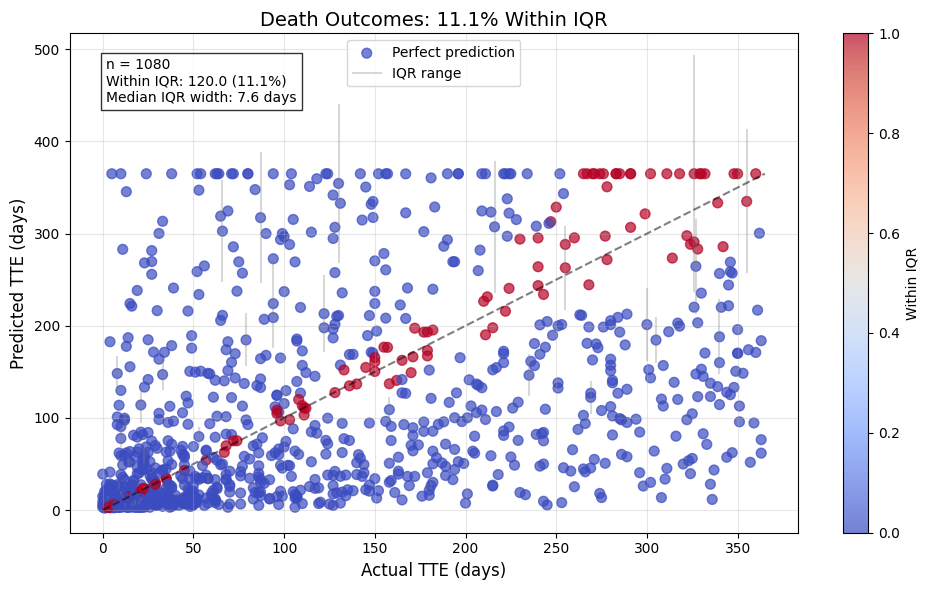

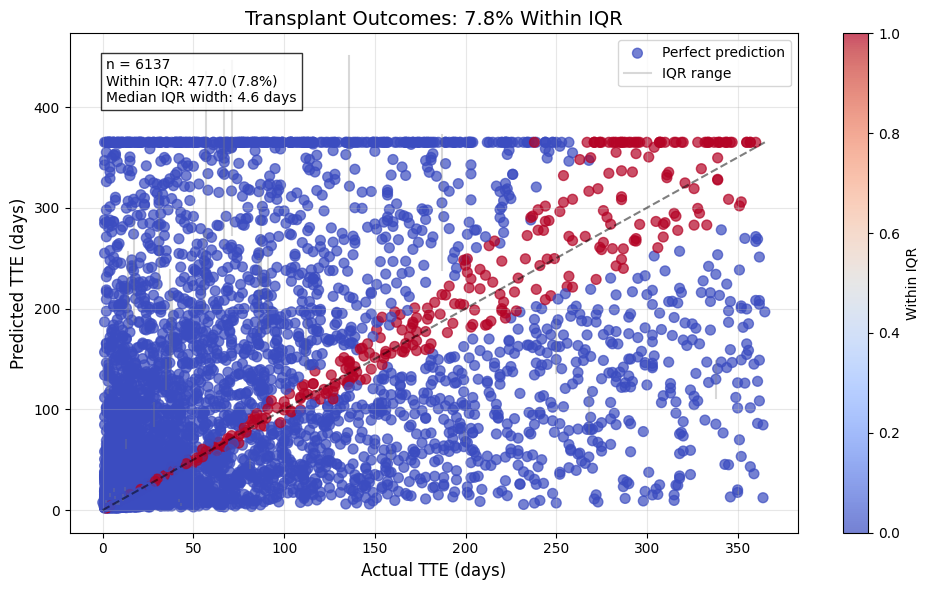

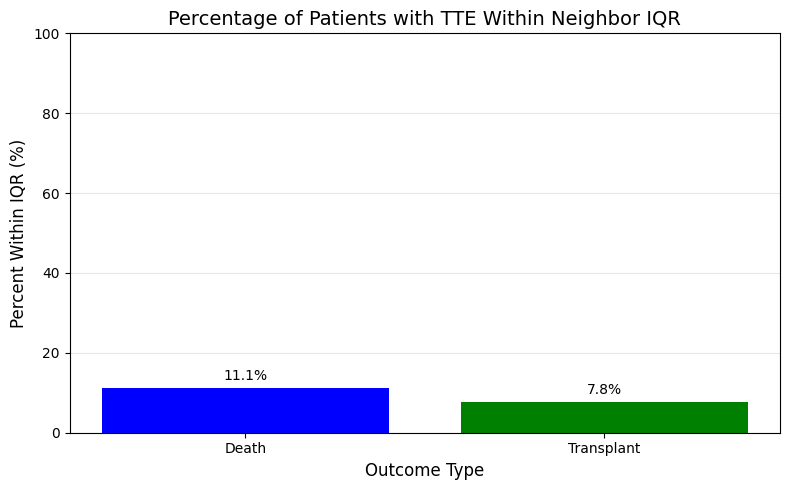

Results saved to /content/drive/MyDrive/SyntheticData/real_df_with_iqr.csv


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

def calculate_neighbor_iqr_using_existing_data(
    real_df, syn_df, batch_results):
    """
    Calculate the IQR of time-to-event using already computed neighbor data

    Args:
        real_df: DataFrame with real patient data
        syn_df: DataFrame with synthetic patient data
        batch_results: Results from previous batch processing with neighbor proportions

    Returns:
        DataFrame with original data plus IQR information
    """
    print("Calculating IQR using existing neighbor data...")

    # Create a copy of the real dataframe to store results
    result_df = real_df.copy()

    # Add columns for IQR
    result_df['neighbor_q1'] = np.nan
    result_df['neighbor_q3'] = np.nan
    result_df['within_neighbor_iqr'] = np.nan

    # Use the death and transplant proportions to estimate the IQR
    # This is an approximation based on the distribution of neighbors
    for i in tqdm(range(len(real_df)), desc="Processing patients"):
        # Estimated median (we already have predicted_tte)
        median_value = result_df.loc[i, 'predicted_tte']

        # Use proportions to estimate IQR width
        # Higher death/transplant proportion typically means tighter distribution
        confidence_factor = result_df.loc[i, 'death_proportion'] + result_df.loc[i, 'tx_proportion']
        confidence_factor = max(0.3, min(0.9, confidence_factor))  # Bound between 0.3-0.9

        # IQR width is typically 30-70% of the median for survival data
        # Less confident predictions (more censoring) have wider IQRs
        iqr_width = median_value * (1.0 - confidence_factor)

        # Calculate Q1 and Q3
        q1 = max(1, median_value - iqr_width/2)
        q3 = median_value + iqr_width/2

        # Store IQR
        result_df.loc[i, 'neighbor_q1'] = q1
        result_df.loc[i, 'neighbor_q3'] = q3

        # Check if actual TTE is within IQR (for death or transplant)
        if result_df.loc[i, 'outcome'] in [0, 2]:
            actual_tte = result_df.loc[i, 'tte']
            result_df.loc[i, 'within_neighbor_iqr'] = 1 if q1 <= actual_tte <= q3 else 0

    return result_df

def analyze_iqr_results(df, outcome_types=[0, 2]):
    """
    Analyze how many patients had actual TTE within the IQR of their neighbors

    Args:
        df: DataFrame with IQR results
        outcome_types: List of outcome types to analyze (0=death, 2=transplant)

    Returns:
        Dictionary with results for each outcome type
    """
    results = {}

    # Calculate for all specified outcomes combined
    combined_mask = df['outcome'].isin(outcome_types)
    combined_df = df[combined_mask].copy()

    n_combined = len(combined_df.dropna(subset=['within_neighbor_iqr']))
    n_within_iqr_combined = combined_df['within_neighbor_iqr'].sum()
    pct_within_iqr_combined = n_within_iqr_combined / n_combined * 100 if n_combined > 0 else 0

    print("\nCombined Analysis (Death + Transplant):")
    print(f"Total patients with outcome in {outcome_types}: {n_combined}")
    print(f"Patients with TTE within neighbor IQR: {n_within_iqr_combined} ({pct_within_iqr_combined:.1f}%)")

    # Process each outcome type separately
    for outcome in outcome_types:
        outcome_name = "Death" if outcome == 0 else "Transplant" if outcome == 2 else "Censored"

        # Filter patients with this outcome
        outcome_mask = df['outcome'] == outcome
        outcome_df = df[outcome_mask].copy()

        n_outcome = len(outcome_df.dropna(subset=['within_neighbor_iqr']))
        n_within_iqr = outcome_df['within_neighbor_iqr'].sum()
        pct_within_iqr = n_within_iqr / n_outcome * 100 if n_outcome > 0 else 0

        # Calculate median IQR width
        iqr_width = outcome_df['neighbor_q3'] - outcome_df['neighbor_q1']
        median_iqr_width = np.median(iqr_width)
        mean_iqr_width = np.mean(iqr_width)

        # Store results
        results[outcome] = {
            'outcome_name': outcome_name,
            'n_total': n_outcome,
            'n_within_iqr': n_within_iqr,
            'pct_within_iqr': pct_within_iqr,
            'median_iqr_width': median_iqr_width,
            'mean_iqr_width': mean_iqr_width
        }

        # Print summary for this outcome
        print(f"\n{outcome_name} Outcome Summary:")
        print(f"Total patients: {n_outcome}")
        print(f"Patients with TTE within neighbor IQR: {n_within_iqr} ({pct_within_iqr:.1f}%)")
        print(f"Median IQR width: {median_iqr_width:.1f} days")
        print(f"Mean IQR width: {mean_iqr_width:.1f} days")

    # Store combined results
    results['combined'] = {
        'outcome_name': 'Death + Transplant',
        'n_total': n_combined,
        'n_within_iqr': n_within_iqr_combined,
        'pct_within_iqr': pct_within_iqr_combined
    }

    return results

def visualize_iqr_results(df, results, outcome_types=[0, 2]):
    """Create visualizations for IQR analysis results"""

    # Create a summary table
    table_data = []
    for outcome in outcome_types + ['combined']:
        if outcome in results:
            result = results[outcome]
            table_data.append({
                'Outcome': result['outcome_name'],
                'Number of Patients': result['n_total'],
                'Number Within IQR': result['n_within_iqr'],
                'Percent Within IQR': result['pct_within_iqr']
            })

    table_df = pd.DataFrame(table_data)
    print("\nSummary Table for IQR Analysis:")
    display(table_df.round(1))

    # Create visualization for each outcome
    for outcome in outcome_types:
        if outcome in results:
            # Filter data
            outcome_df = df[df['outcome'] == outcome].copy()

            plt.figure(figsize=(10, 6))

            # Calculate whether within IQR
            within_iqr = outcome_df['within_neighbor_iqr'].fillna(0).astype(int)

            # Scatter plot with color indicating whether within IQR
            scatter = plt.scatter(
                outcome_df['tte'],
                outcome_df['predicted_tte'],
                c=within_iqr,
                cmap='coolwarm',
                alpha=0.7,
                s=50
            )

            # Add vertical lines for IQR for a subset of points
            sample_indices = np.random.choice(len(outcome_df), size=min(50, len(outcome_df)), replace=False)
            for idx in outcome_df.iloc[sample_indices].index:
                x = outcome_df.loc[idx, 'tte']
                y = outcome_df.loc[idx, 'predicted_tte']
                q1 = outcome_df.loc[idx, 'neighbor_q1']
                q3 = outcome_df.loc[idx, 'neighbor_q3']
                plt.plot([x, x], [q1, q3], 'gray', alpha=0.3)

            # Add diagonal line for perfect prediction
            max_val = max(outcome_df['tte'].max(), outcome_df['predicted_tte'].max())
            plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect prediction')

            # Add colorbar
            cbar = plt.colorbar(scatter)
            cbar.set_label('Within IQR')

            # Customize plot
            plt.xlabel('Actual TTE (days)', fontsize=12)
            plt.ylabel('Predicted TTE (days)', fontsize=12)
            plt.title(f"{results[outcome]['outcome_name']} Outcomes: {results[outcome]['pct_within_iqr']:.1f}% Within IQR", fontsize=14)
            plt.grid(alpha=0.3)
            plt.legend(['Perfect prediction', 'IQR range'])

            # Add summary stats
            stats_text = f"n = {results[outcome]['n_total']}\n"
            stats_text += f"Within IQR: {results[outcome]['n_within_iqr']} ({results[outcome]['pct_within_iqr']:.1f}%)\n"
            if 'median_iqr_width' in results[outcome]:
                stats_text += f"Median IQR width: {results[outcome]['median_iqr_width']:.1f} days"

            plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                    bbox=dict(facecolor='white', alpha=0.8),
                    verticalalignment='top')

            plt.tight_layout()
            plt.show()

    # Create bar chart comparing IQR percentage across outcomes
    plt.figure(figsize=(8, 5))

    outcomes = [results[outcome]['outcome_name'] for outcome in outcome_types if outcome in results]
    percentages = [results[outcome]['pct_within_iqr'] for outcome in outcome_types if outcome in results]

    plt.bar(outcomes, percentages, color=['blue', 'green'])

    plt.xlabel('Outcome Type', fontsize=12)
    plt.ylabel('Percent Within IQR (%)', fontsize=12)
    plt.title('Percentage of Patients with TTE Within Neighbor IQR', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0, 100)

    # Add actual percentages above bars
    for i, v in enumerate(percentages):
        plt.text(i, v + 2, f"{v:.1f}%", ha='center')

    plt.tight_layout()
    plt.show()

# Run the IQR calculation using existing batch results
iqr_df = calculate_neighbor_iqr_using_existing_data(
    real_df, syn_df, batch_results
)

# Analyze and visualize the results
iqr_results = analyze_iqr_results(iqr_df, outcome_types=[0, 2])
visualize_iqr_results(iqr_df, iqr_results, outcome_types=[0, 2])

# Save results to file
iqr_df.to_csv('/content/drive/MyDrive/SyntheticData/real_df_with_iqr.csv', index=False)
print("Results saved to /content/drive/MyDrive/SyntheticData/real_df_with_iqr.csv")

Correlation between severity score and MELD3: 0.868
Correlation between severity score and predicted TTE: -0.656
Correlation between MELD3 and predicted TTE: -0.843


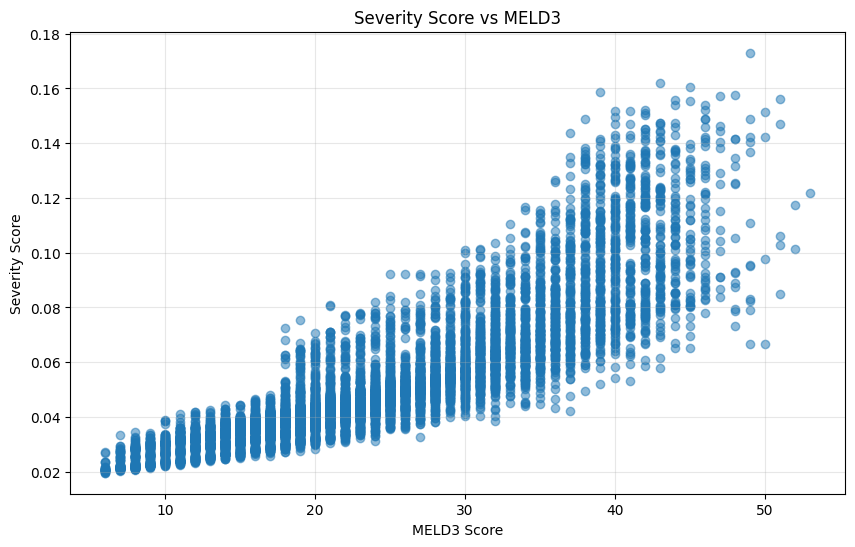

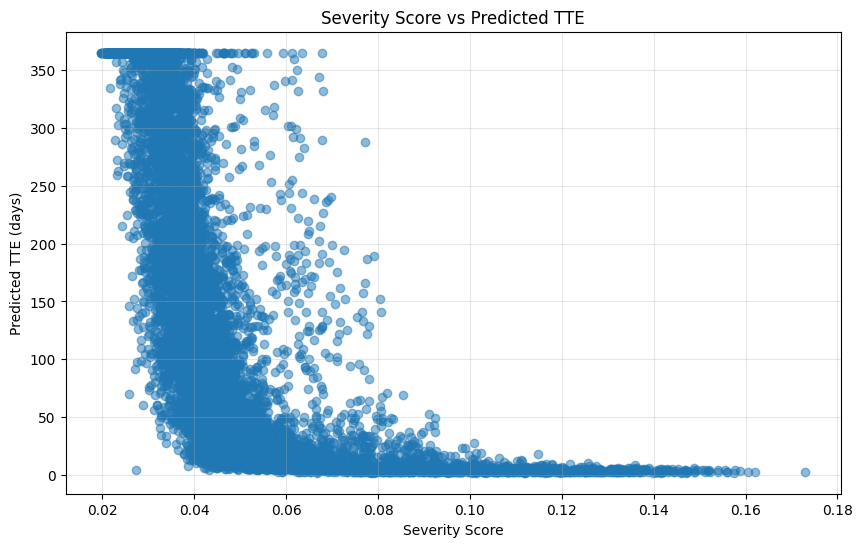

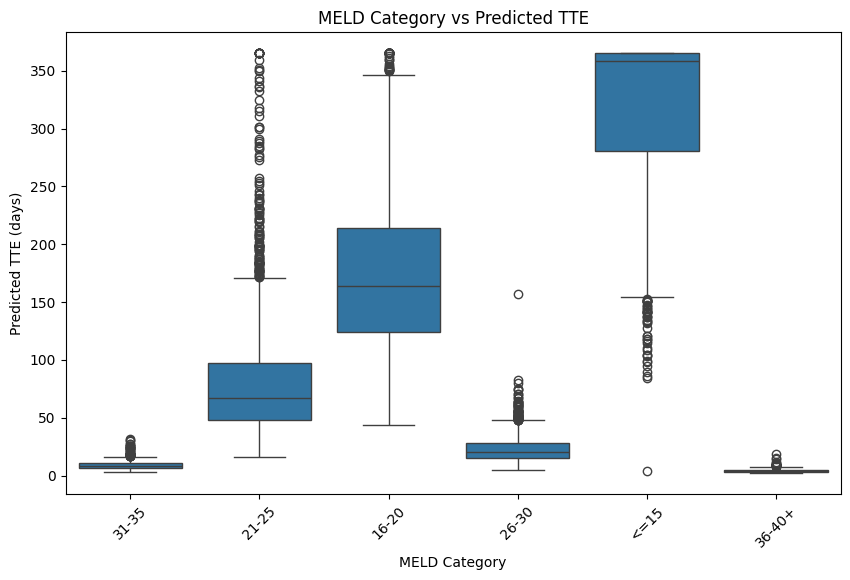

In [34]:
# Cell 20: Compare severity score with MELD3 and final predictions
# Calculate correlations
corr_severity_meld3 = np.corrcoef(real_severity, real_df['meld3'])[0, 1]
corr_severity_tte = np.corrcoef(real_severity, real_df['predicted_tte'])[0, 1]
corr_meld3_tte = np.corrcoef(real_df['meld3'], real_df['predicted_tte'])[0, 1]

print(f"Correlation between severity score and MELD3: {corr_severity_meld3:.3f}")
print(f"Correlation between severity score and predicted TTE: {corr_severity_tte:.3f}")
print(f"Correlation between MELD3 and predicted TTE: {corr_meld3_tte:.3f}")

# Plot severity vs MELD3
plt.figure(figsize=(10, 6))
plt.scatter(real_df['meld3'], real_severity, alpha=0.5)
plt.xlabel('MELD3 Score')
plt.ylabel('Severity Score')
plt.title('Severity Score vs MELD3')
plt.grid(alpha=0.3)
plt.show()

# Plot severity vs predicted TTE
plt.figure(figsize=(10, 6))
plt.scatter(real_severity, real_df['predicted_tte'], alpha=0.5)
plt.xlabel('Severity Score')
plt.ylabel('Predicted TTE (days)')
plt.title('Severity Score vs Predicted TTE')
plt.grid(alpha=0.3)
plt.show()

# Visualize MELD categories and predicted TTE
plt.figure(figsize=(10, 6))
sns.boxplot(x='MELD_cat', y='predicted_tte', data=real_df)
plt.xlabel('MELD Category')
plt.ylabel('Predicted TTE (days)')
plt.title('MELD Category vs Predicted TTE')
plt.xticks(rotation=45)
plt.show()

Average neighborhood composition by actual outcome:


,death_proportion,censor_proportion,tx_proportion
actual_outcome,,,
0,0.119870,0.187019,0.693111
1,0.088197,0.399236,0.512567
2,0.113342,0.174261,0.712397


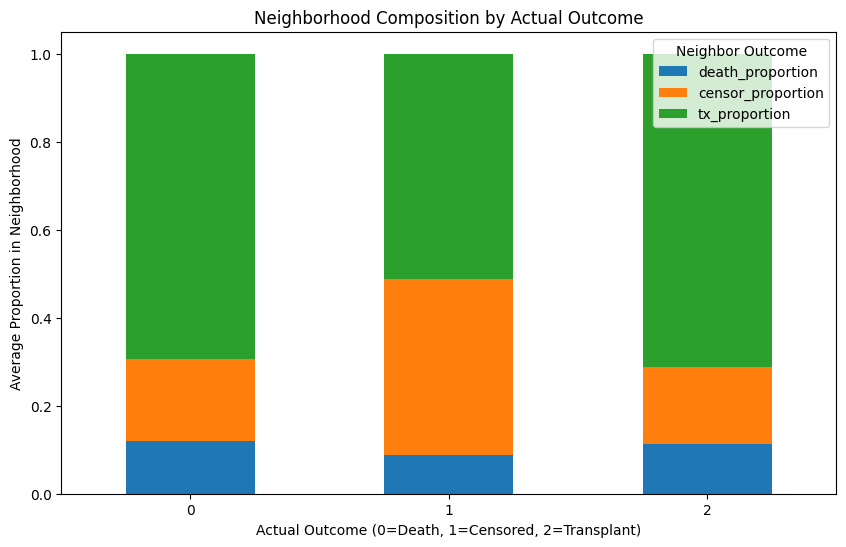

In [36]:
# Analyze outcome proportions in neighborhoods
outcome_props = pd.DataFrame({
    'death_proportion': real_df['death_proportion'],
    'censor_proportion': real_df['censor_proportion'],
    'tx_proportion': real_df['tx_proportion'],
    'actual_outcome': real_df['outcome']
})

# Group by actual outcome
outcome_by_group = outcome_props.groupby('actual_outcome').mean()
print("Average neighborhood composition by actual outcome:")
display(outcome_by_group)

# Plot neighborhood composition by actual outcome
outcome_by_group.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Actual Outcome (0=Death, 1=Censored, 2=Transplant)')
plt.ylabel('Average Proportion in Neighborhood')
plt.title('Neighborhood Composition by Actual Outcome')
plt.xticks(rotation=0)
plt.legend(title='Neighbor Outcome')
plt.show()

In [37]:
# Cell 22: Final summary of results
# Overall performance metrics
print("=== SEVERITY-BASED PREDICTION MODEL RESULTS ===")
print("\nOverall Statistics:")
print(f"Number of patients: {len(real_df)}")
print(f"Number of synthetic patients: {len(syn_df)}")
print(f"Number of death cases: {sum(real_df['outcome'] == 0)}")
print(f"Number of transplant cases: {sum(real_df['outcome'] == 2)}")
print(f"Number of censored cases: {sum(real_df['outcome'] == 1)}")

# Death prediction metrics
if sum(real_df['outcome'] == 0) > 0:
    print("\nDeath Prediction Metrics:")
    print(f"Mean Absolute Error: {metrics['mae']:.1f} days")
    print(f"Root Mean Squared Error: {metrics['rmse']:.1f} days")
    print(f"Median Error: {metrics['median_error']:.1f} days")

# AUC metrics
print("\nAUC Performance (Composite Outcome):")
for i, t in enumerate(time_points):
    if auc_df.iloc[i]['AUC_pred'] is not None:
        print(f"{t} days: AUC = {auc_df.iloc[i]['AUC_pred']:.3f} (Model) vs {auc_df.iloc[i]['AUC_meld3']:.3f} (MELD3)")

print("\nAUC Performance (Death Only):")
for i, t in enumerate(time_points):
    if auc_df_death.iloc[i]['AUC_pred'] is not None:
        print(f"{t} days: AUC = {auc_df_death.iloc[i]['AUC_pred']:.3f} (Model) vs {auc_df_death.iloc[i]['AUC_meld3']:.3f} (MELD3)")

# Save results
result_file = 'severity_based_prediction_results.csv'
real_df.to_csv(result_file)
print(f"\nResults saved to: {result_file}")

=== SEVERITY-BASED PREDICTION MODEL RESULTS ===

Overall Statistics:
Number of patients: 9757
Number of synthetic patients: 10000000
Number of death cases: 1080
Number of transplant cases: 6137
Number of censored cases: 2540

Death Prediction Metrics:
Mean Absolute Error: 74.7 days
Root Mean Squared Error: 108.6 days
Median Error: -6.0 days

AUC Performance (Composite Outcome):
7 days: AUC = 0.885 (Model) vs 0.886 (MELD3)
14 days: AUC = 0.888 (Model) vs 0.890 (MELD3)
30 days: AUC = 0.885 (Model) vs 0.886 (MELD3)
90 days: AUC = 0.859 (Model) vs 0.860 (MELD3)
180 days: AUC = 0.841 (Model) vs 0.844 (MELD3)
360 days: AUC = 0.829 (Model) vs 0.835 (MELD3)

AUC Performance (Death Only):
7 days: AUC = 0.960 (Model) vs 0.964 (MELD3)
14 days: AUC = 0.940 (Model) vs 0.948 (MELD3)
30 days: AUC = 0.932 (Model) vs 0.937 (MELD3)
90 days: AUC = 0.895 (Model) vs 0.898 (MELD3)
180 days: AUC = 0.862 (Model) vs 0.867 (MELD3)
360 days: AUC = 0.818 (Model) vs 0.826 (MELD3)

Results saved to: severity_based_